# Load Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mp_patches

## Get Files

In [2]:
url = 'https://drive.google.com/file/d/1ZQdlefQ9xWj4eLWshaTloqiq63mP6zB8/view?usp=sharing'
batch_name = '151121_two_hydrophone'

In [3]:
!ls "{batch_name}.tar.xz" 2>/dev/null || (python -m pip install gdown --upgrade > /dev/null && gdown --fuzzy "{url}")

151121_two_hydrophone.tar.xz


In [4]:
!ls "{batch_name}" 2>/dev/null 1>/dev/null || tar xvf "{batch_name}.tar.xz"

In [5]:
runs = {
    0.00: ('d000_1', 'd000_2',),
    0.65: ('d065_1', 'd065_2',),
    1.25: ('d125_1', 'd125_2',),
}

In [6]:
fs = 1e6
dt = 1.0 / fs
v_sound = 1480

## Loader

In [7]:
import numpy as np
import struct

from scipy.signal import butter, lfilter, filtfilt, hilbert
class BP:
    def __init__(self, fs=1e6, low=30e3, high=50e3, order=5, preserve_phase=False):
        nyq = 0.5 * fs
        self.coeffs = butter(order, [low / nyq, high / nyq], btype='band')
        self.apply = filtfilt if preserve_phase else lfilter

    def __call__(self, data):
        return self.apply(*self.coeffs, data, axis=0)

class MA:
    def __init__(self, fs=1e6, dt=1e-3):
        self.n = int(fs * dt)
        self.kernel = np.ones((self.n,), dtype=np.int32) / self.n

    def __call__(self, data):
        if len(data.shape) == 1:
            return np.convolve(np.abs(data), self.kernel, mode='same')

        out = np.empty_like(data)
        for i in range(data.shape[1]):
            out[:, i] = np.convolve(np.abs(data[:, i]), self.kernel, mode='same')
        return out

class Hilbert:
    def __init__(self, fs=1e6):
        pass

    def __call__(self, data):
        return np.abs(hilbert(data))

class PicoDataLoader:
    bufsize = 100000
    time_len = struct.calcsize('<d')
    time_unpack = struct.Struct('<d').unpack_from
    
    def __init__(self, filename, # filename: Union[str, path_like, File object]
                 bp_args={'fs': fs, 'low': 35e3, 'high':45e3},
                 ma_args={'fs': fs, 'dt': 6e-5}):  
        self.filename = filename
        self.file = None

        self.transformers = []
        if bp_args:
            self.transformers.append(BP(**bp_args))
        if ma_args:
            self.transformers.append(MA(**ma_args))
    
    def open(self):
        # For compatibility with tarfiles
        # See: https://github.com/numpy/numpy/issues/7989#issuecomment-340921579
        if self.file is not None:
            self.close()
        import io
        if isinstance(self.filename, io.BufferedReader):
          array_file = io.BytesIO()
          array_file.write(self.filename.read())
          array_file.seek(0)
          self.file = array_file
        else:
          self.file = open(self.filename, 'rb')
    
    def get(self):
        if self.file is None:
            raise Exception("Use ```open``` and ```close```")
        try:
            t = self.time_unpack(self.file.read(self.time_len))[0]
            arr = np.load(self.file)
            dtype = arr.dtype
            for tran in self.transformers:
                arr = tran(arr)
            return t, arr.astype(dtype)
        except ValueError:
            raise StopIteration()
        except struct.error:
            raise StopIteration()

    def close(self):
        if self.file is not None:
            self.file.close()

    def __enter__(self):
        self.open()
        return self
    def __exit__(self ,type, value, traceback):
        self.close()

In [9]:
import itertools
import numpy as np


# TODO: how to deal with multiple sets of zero crossing,
# TODO: groupby can bre replaced my numpy indexing i think
# notes for function def stage_1(signal, winsize_zero_cross, fs, run_plot)
# stage 1 does the following processes:
# 1. filter use IIR bandpass filters
# 2. estimate the zero-crossing of the first peak in two stages
#    first of which is approximate position where first peak crosses the threshold of 10% of signal mean
#    second stage, wherein use curvature of the signal to estimate a more-accurate estimate of zero-crossing
# Availible defaults           500,1e6,                    0,
def Est_ZC_stage_1(signal, winsize, std_noise_multiplier, run_plot=False, plot_title='zero_crossing'):
    def sum_index(index_limit, reshaped_group_results_len):
        ind_count = 0
        for k in range(0, index_limit):
            ind_count = ind_count + reshaped_group_results_len[k]
        return ind_count

    def ZC_estimation(signal_h, noise_threshold, n_max_p):

        # estimate out part of the signal which is > threshold
        results = np.where(signal_h > noise_threshold, True, False)

        # itertools groupby aims to group the array in groups of True and False
        # where g is the groups and k is unique key/ value in each group
        # size/ length of the groups is given by len(list(g)) and is stored as an np.array
        group_results_len = np.array([len(list(g)) for k, g in itertools.groupby(results)])

        # only the first value of each groups (True or False) is stored in this array - will now correspond to each group
        # for which length are estimated previously
        group_results_value = np.array([list(g)[0] for k, g in itertools.groupby(results)])

        # indices & group-length wherein corresponding value in group_results_value is True
        ind_of_group_results_value_for_trues = np.array(np.where(group_results_value == True))
        group_len_counts_of_true = (group_results_len[ind_of_group_results_value_for_trues])

        # indices of top n_max maximuma of group_len_counts_of_true
        ind_n_max_group_len_counts_of_true = np.array(np.argsort(-group_len_counts_of_true))

        # manipulations to match the shape of the arrays
        group_len_counts_of_true = group_len_counts_of_true.T
        ind_n_max_group_len_counts_of_true = ind_n_max_group_len_counts_of_true.T

        # how many maxs (top-n) need to be estimated?
        n_max = int(len(group_len_counts_of_true) * n_max_p / 100)
        if n_max <= 2:
            n_max = int(len(group_len_counts_of_true))

        ind_n_max_group_len_counts_of_true = np.array(ind_n_max_group_len_counts_of_true[0:n_max])

        # what are the values of the top-n (sorted) group-lengths of trues?
        values_maxes_in_group_results_len = np.array((group_len_counts_of_true[ind_n_max_group_len_counts_of_true]))
        values_maxes_in_group_results_len = np.reshape(values_maxes_in_group_results_len, (n_max, 1))

        # manipulations to match the shape of the arrays
        reshaped_group_results_len = np.reshape(group_results_len, (len(group_results_len), 1))

        # elementwise comparison of the arrays to estimate the starting indices of the n_max groups of True:
        # comparison with the entire (true-false) list
        ind_of_max_in_group_results_len = np.array(np.where(np.in1d(reshaped_group_results_len,
                                                                    values_maxes_in_group_results_len)))

        index_max_counts_of_true = np.zeros((len(ind_of_max_in_group_results_len), 1))
        for i in range(len(ind_of_max_in_group_results_len)):
            try:
                index_max_counts_of_true[i] = sum_index(ind_of_max_in_group_results_len[i, 0],
                                                        reshaped_group_results_len) + 1
            except:
                index_max_counts_of_true[i] = 0
                break

        Q_zero_cross_index = (np.min(index_max_counts_of_true[:, 0])).astype(int)

        return Q_zero_cross_index

    def plot_ZC(signal_h, Q_zero_cross_index, plot_title, winsize):
        import matplotlib.pyplot as plt
        from matplotlib.patches import Rectangle
        index = Q_zero_cross_index
        fig, axs = plt.subplots(1, figsize=(10,4))
        fig.suptitle(plot_title)
        axs.plot(signal_h, label='bandpass')
        axs.plot(np.repeat(0, len(signal_h)), 'k--', label='zero level')
        axs.plot(np.repeat(noise_threshold_1, len(signal_h)), 'r--', label='noise_threshold_1')
        axs.plot(np.repeat(noise_threshold_2, len(signal_h)), 'b--', label='noise_threshold_2')
        axs.plot(index, signal_h[index], 'o')
        rect = Rectangle((index, 0), winsize * 2, np.max(signal_h) / 2, linewidth=3, edgecolor='r', facecolor='none')
        axs.add_patch(rect)
        axs.legend()

    # filter first and then, normalise the signal for further processing
    # estimate the envelope of the rectified signal using the hilbert transform
    # estimate threshold
    threshold = (np.mean(signal))
    signal_noise_h = np.where(signal > threshold, 0, signal)
    noise_threshold_1 = np.mean(signal_noise_h) + std_noise_multiplier * np.std(signal_noise_h)
    noise_threshold_1 = 200
    # print('noise_threshold_1', noise_threshold_1)

    # first iteration
    n_max_p = 5
    init_est_ZC_index = ZC_estimation(signal, noise_threshold_1, n_max_p)
    # print(f'init_est_ZC_index - {plot_title}', init_est_ZC_index)

    # attempt to check the samples in the neighbourhood
    hori_check_indices = np.linspace(max(init_est_ZC_index - winsize,0), min(init_est_ZC_index + winsize,signal.shape[0] - 1), winsize * 2, dtype=int)
    if np.all(signal[hori_check_indices] < 10 * noise_threshold_1):
        init_est_ZC_index = ZC_estimation(signal, noise_threshold_1 * 2, n_max_p)

    # attempt to check the samples in the neighbourhood by selecting a window with elevated threshold
    noise_threshold_2 = noise_threshold_1 * 1.25
    # print('noise_threshold_2', noise_threshold_2)
    second_est_ZC_index = 0
    if signal[init_est_ZC_index] >= 3 * noise_threshold_1:
        # second iteration
        n_max_p = 50
        sub_signal = signal[init_est_ZC_index - winsize: init_est_ZC_index + winsize]
        ZC_subsignal = ZC_estimation(sub_signal, noise_threshold_2, n_max_p)
        # print(f'ZC_subsignal - {plot_title}', ZC_subsignal)
        second_est_ZC_index = init_est_ZC_index + (ZC_subsignal - winsize)
        # print(f'second_est_ZC_index - {plot_title}', second_est_ZC_index)

    if second_est_ZC_index != 0:
        ZC_index = second_est_ZC_index
    else:
        ZC_index = init_est_ZC_index

    if run_plot:
        plot_ZC(signal, ZC_index, plot_title, winsize)

    return ZC_index


In [10]:
from tqdm.notebook import trange
import subprocess

class FancyLoader:
  def __init__(self):
    self.runs = {
        0.00: ('d000_1', 'd000_2',),
        0.65: ('d065_1', 'd065_2',),
        1.25: ('d125_1', 'd125_2',),
    }

    self.data = {
        0.00: [None, None],
        0.65: [None, None],
        1.25: [None, None],
    }

  def __getitem__(self, key):  # -> t, data
    dist, number = key
    if not (dist in self.runs.keys() and 0 <= number < len(self.runs[dist])):
      raise IndexError(f"Invalid run index.")
    
    if self.data[dist][number] is not None:
      return self.data[dist][number]

    filename = batch_name + '/' + self.runs[dist][number] + '/pico.npts'

    with PicoDataLoader(filename, bp_args=None, ma_args=None) as reader:
        t0 = reader.get()[0]
    
    num_chunks = int(int(subprocess.run(f'du {reader.filename} | cut -f 1', shell=True, capture_output=True).stdout.decode('UTF-8')) // 976.7 + 1)

    arrs = []
    t_curr = t0
    with PicoDataLoader(filename, bp_args=None, ma_args=None) as reader:
        try:
            for i in trange(num_chunks, desc=f'{self.runs[dist][number]}: '):
                t, arr = reader.get()
                arr = arr[:, :2]
                arrs.append(arr)
                t_curr += dt * arr.shape[0]
        except StopIteration:
            print(f"Got {len(arrs)} chunks of {num_chunks} expected")

    y = np.vstack(arrs)
    t = np.arange(y.shape[0]) * dt
    del arrs

    t.flags.writeable = False
    y.flags.writeable = False
    
    self.data[dist][number] = t, y

    return self.data[dist][number]

data_loader = FancyLoader()

# Get Optimal BP

## Load Bucket Data

In [11]:
  url = 'https://drive.google.com/file/d/12gDwtay-NWyfgPa-Z8HMM5P2Ur-pTK34/view?usp=sharing'
  filename = 'office_1.npz'

In [12]:
!ls "{filename}" 2>/dev/null || (python -m pip install gdown --upgrade > /dev/null && gdown --fuzzy "{url}")

Downloading...
From: https://drive.google.com/uc?id=12gDwtay-NWyfgPa-Z8HMM5P2Ur-pTK34
To: /home/suraj/PycharmProjects/positioning/241121_new_zero_crossing/office_1.npz
100%|████████████████████████████████████████| 480M/480M [01:31<00:00, 5.26MB/s]


In [13]:
bucket_data = np.load(filename)['data']
bdata = (bucket_data[:, 1:] * (2**15 - 1) / 7).astype('int16')
bt = bucket_data[:, 0]

## Load Pool Data

In [14]:
dist = 0.65
t, y = data_loader[dist, 0]

d065_1:   0%|          | 0/465 [00:00<?, ?it/s]

Got 464 chunks of 465 expected


## BP Analysis: Bucket v Pool

### 20->50

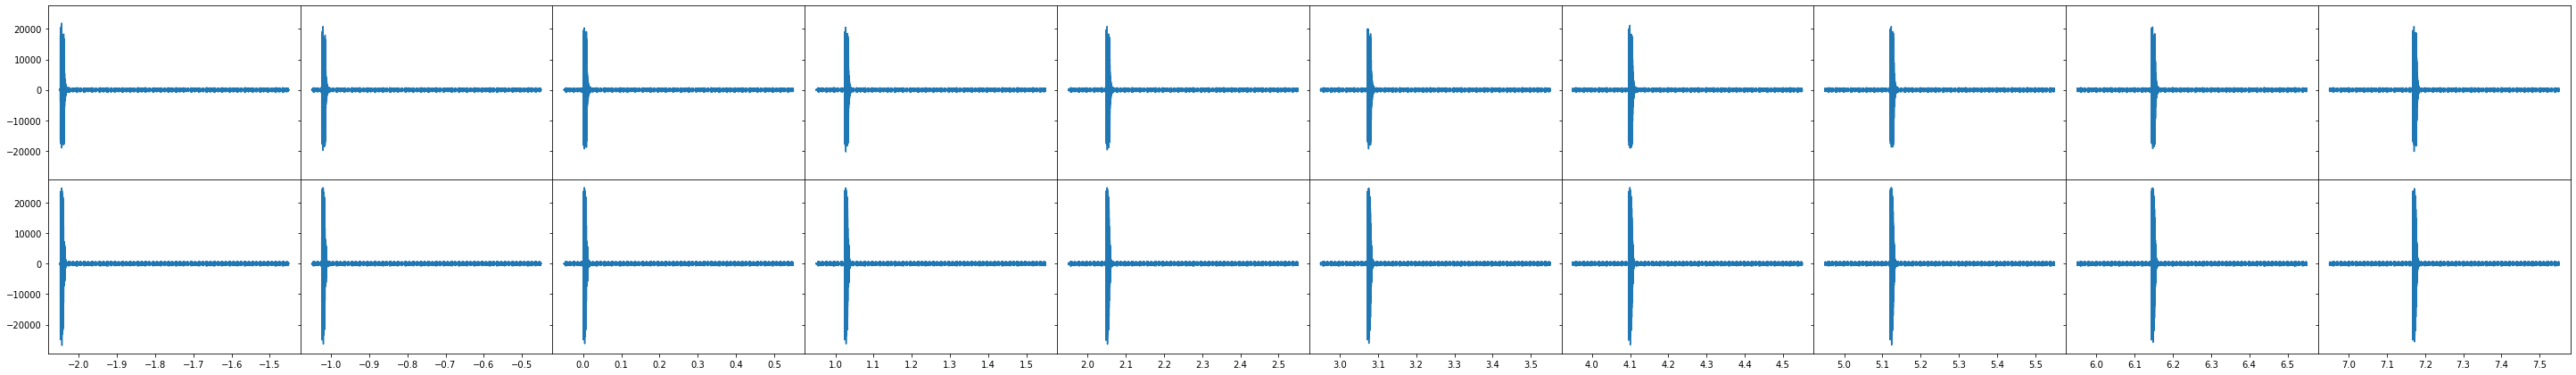

In [15]:
bp_args={'fs': fs, 'low': 20e3, 'high': 50e3}
bp = BP(**bp_args)
get_win = lambda i: slice(int(fs*(i+0.25)), int(fs*(i+0.85)))
f, axs = plt.subplots(2, 10, sharex='col', sharey=True, figsize=(40,6))
f.tight_layout()
for i, ax in enumerate(zip(*axs)):
    win = get_win(i)
    ax[0].plot(bt[win], bp(bdata[win,0]))
    ax[1].plot(bt[win], bp(bdata[win,1]))
f.subplots_adjust(wspace=0, hspace=0)

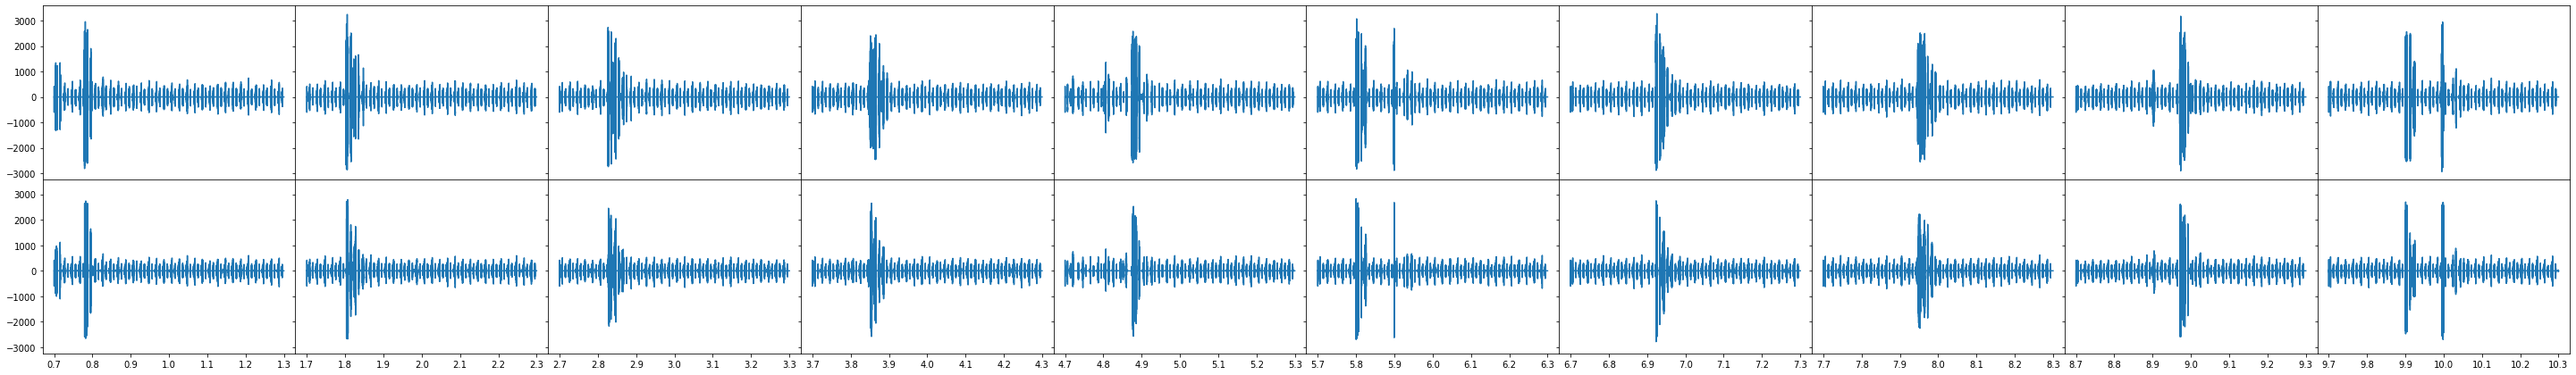

In [16]:
bp_args={'fs': fs, 'low': 20e3, 'high': 50e3}
bp = BP(**bp_args)
get_win = lambda i: slice(int(fs*(i+0.7)), int(fs*(i+1.3)))
f, axs = plt.subplots(2, 10, sharex='col', sharey=True, figsize=(40,6))
f.tight_layout()
for i, ax in enumerate(zip(*axs)):
    win = get_win(i)
    ax[0].plot(t[win], bp(y[win,0]))
    ax[1].plot(t[win], bp(y[win,1]))
f.subplots_adjust(wspace=0, hspace=0)

### 35->40

/tmp/ipykernel_5625/1074610948.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


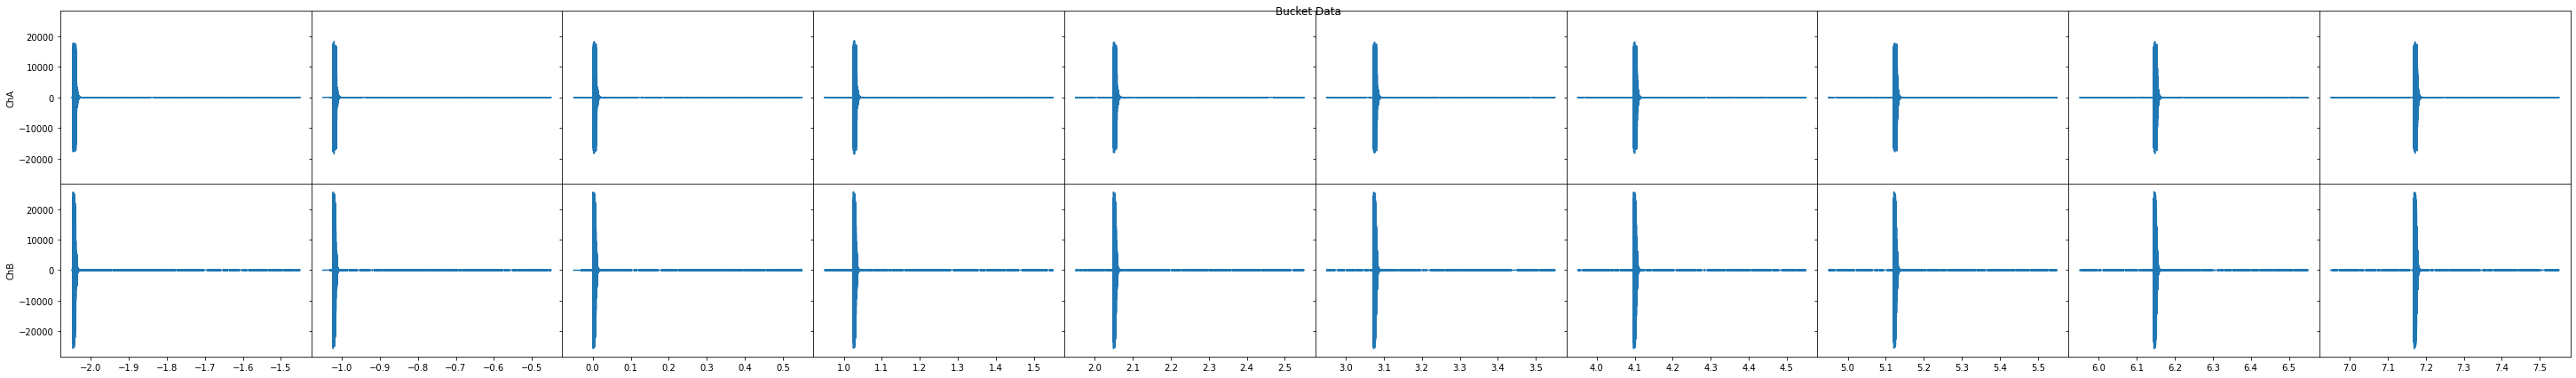

In [17]:
bp_args={'fs': fs, 'low': 35e3, 'high': 40e3}
bp = BP(**bp_args)
get_win = lambda i: slice(int(fs*(i+0.25)), int(fs*(i+0.85)))
f, axs = plt.subplots(2, 10, sharex='col', sharey=True, figsize=(40,6))
f.tight_layout()
for i, ax in enumerate(zip(*axs)):
    win = get_win(i)
    ax[0].plot(bt[win], bp(bdata[win,0]))
    ax[1].plot(bt[win], bp(bdata[win,1]))
f.subplots_adjust(wspace=0, hspace=0)

for i, ax in enumerate(zip(*axs)):
    ax[0].set_ylabel("ChA")
    ax[1].set_ylabel("ChB")
    break
f.suptitle("Bucket Data")
f.show()

/tmp/ipykernel_5625/3524380163.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


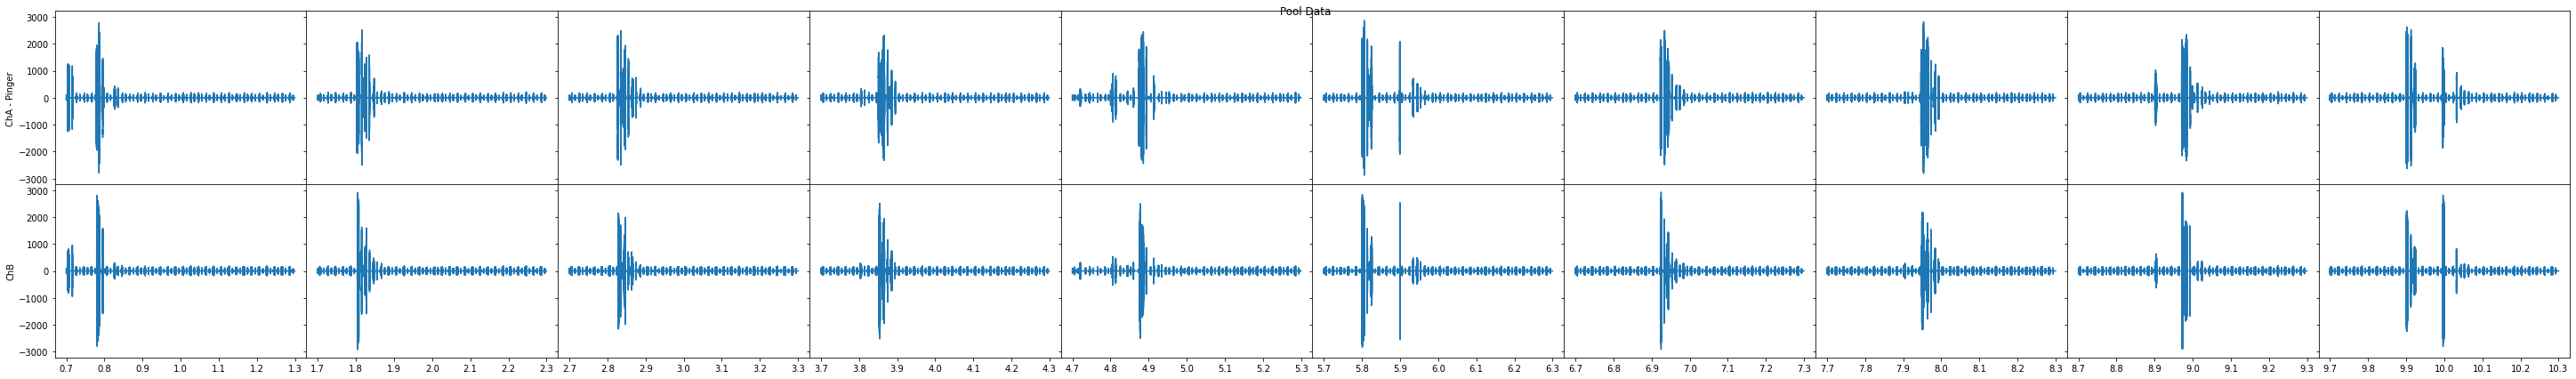

In [18]:
bp_args={'fs': fs, 'low': 35e3, 'high':40e3}
bp = BP(**bp_args)
get_win = lambda i: slice(int(fs*(i+0.7)), int(fs*(i+1.3)))
f, axs = plt.subplots(2, 10, sharex='col', sharey=True, figsize=(40,6))
f.tight_layout()
for i, ax in enumerate(zip(*axs)):
    win = get_win(i)
    ax[0].plot(t[win], bp(y[win,0]))
    ax[1].plot(t[win], bp(y[win,1]))
f.subplots_adjust(wspace=0, hspace=0)

for i, ax in enumerate(zip(*axs)):
    ax[0].set_ylabel("ChA - Pinger")
    ax[1].set_ylabel("ChB")
    break
f.suptitle("Pool Data")
f.show()

### w/MA

/tmp/ipykernel_5625/227892640.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


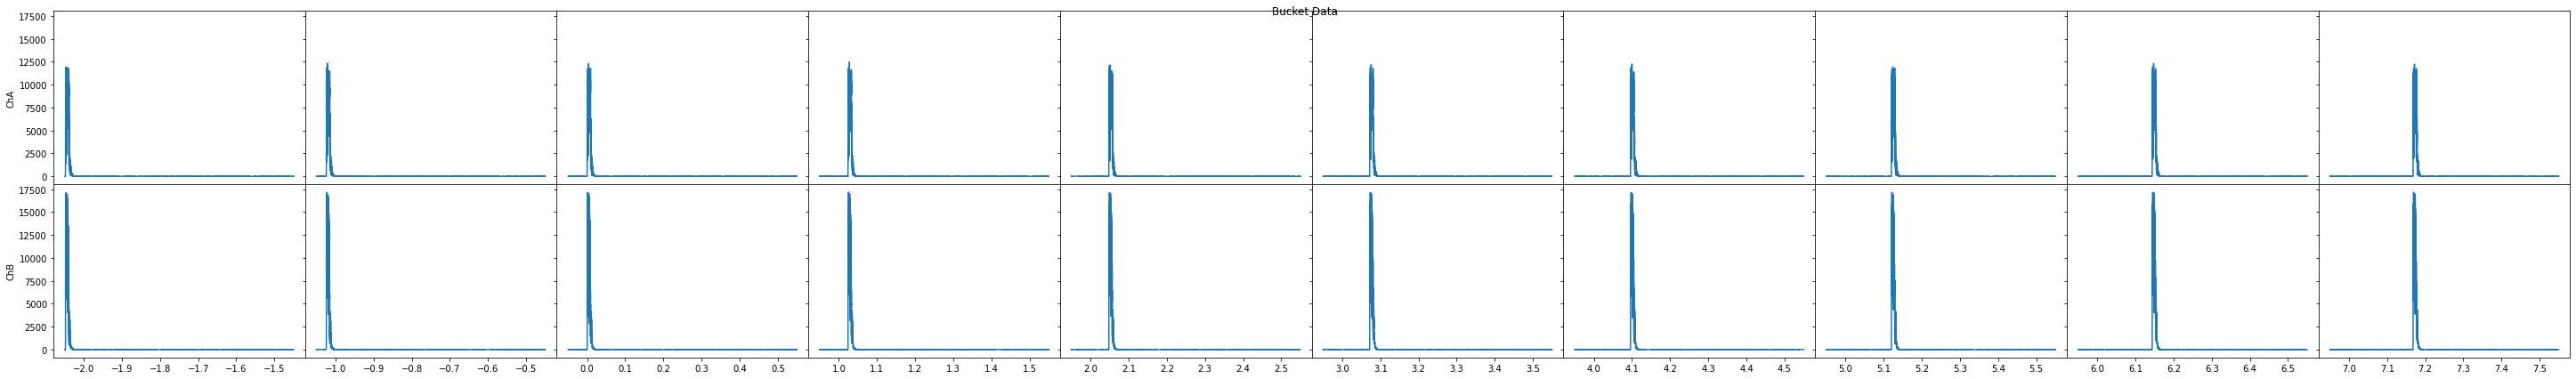

In [19]:
bp_args={'fs': fs, 'low': 35e3, 'high': 40e3}
bp = BP(**bp_args)
ma = MA(fs=fs, dt=3e-5)
get_win = lambda i: slice(int(fs*(i+0.25)), int(fs*(i+0.85)))
f, axs = plt.subplots(2, 10, sharex='col', sharey=True, figsize=(40,6))
f.tight_layout()
for i, ax in enumerate(zip(*axs)):
    win = get_win(i)
    ax[0].plot(bt[win], ma(bp(bdata[win,0])))
    ax[1].plot(bt[win], ma(bp(bdata[win,1])))
f.subplots_adjust(wspace=0, hspace=0)

for i, ax in enumerate(zip(*axs)):
    ax[0].set_ylabel("ChA")
    ax[1].set_ylabel("ChB")
    break
f.suptitle("Bucket Data")
f.show()

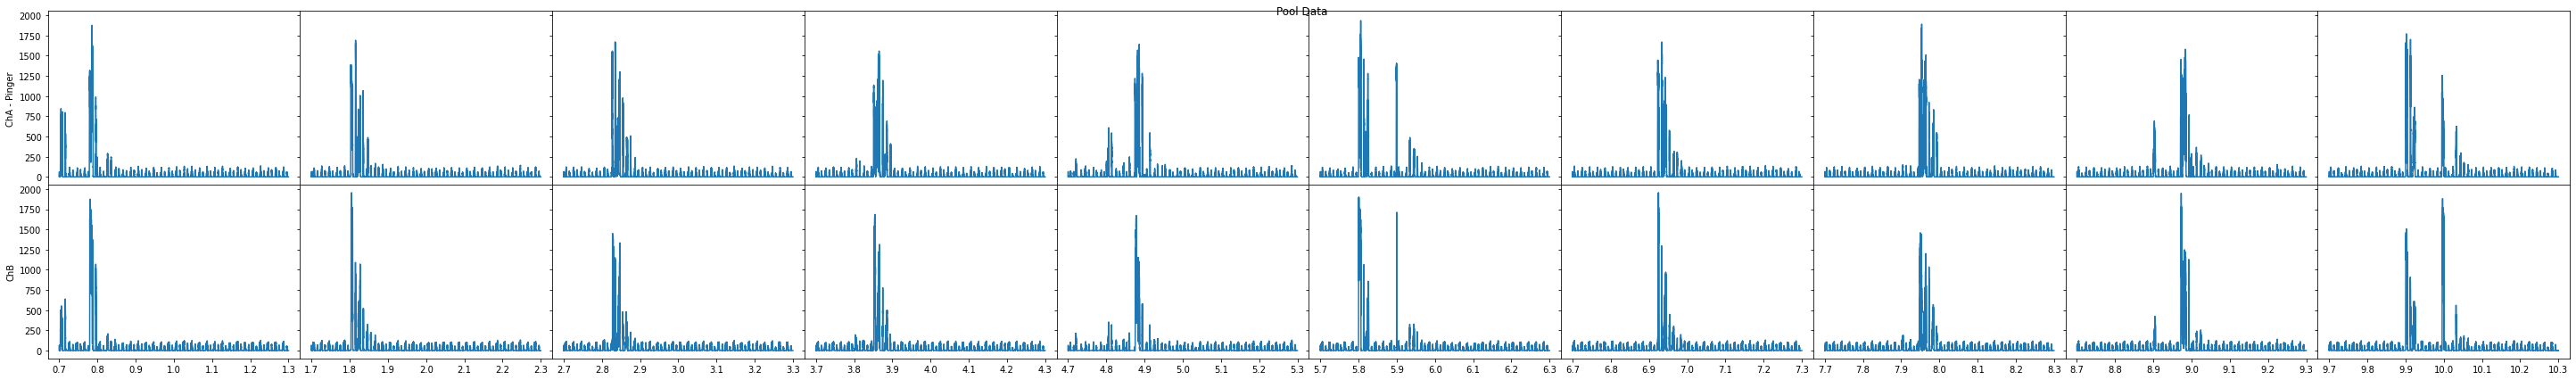

In [ ]:
bp_args={'fs': fs, 'low': 35e3, 'high':40e3}
bp = BP(**bp_args)
ma = MA(fs=fs, dt=3e-5)
get_win = lambda i: slice(int(fs*(i+0.7)), int(fs*(i+1.3)))
f, axs = plt.subplots(2, 10, sharex='col', sharey=True, figsize=(40,6))
f.tight_layout()
for i, ax in enumerate(zip(*axs)):
    win = get_win(i)
    ax[0].plot(t[win], ma(bp(y[win,0])))
    ax[1].plot(t[win], ma(bp(y[win,1])))
f.subplots_adjust(wspace=0, hspace=0)

for i, ax in enumerate(zip(*axs)):
    ax[0].set_ylabel("ChA - Pinger")
    ax[1].set_ylabel("ChB")
    break
f.suptitle("Pool Data")
f.show()

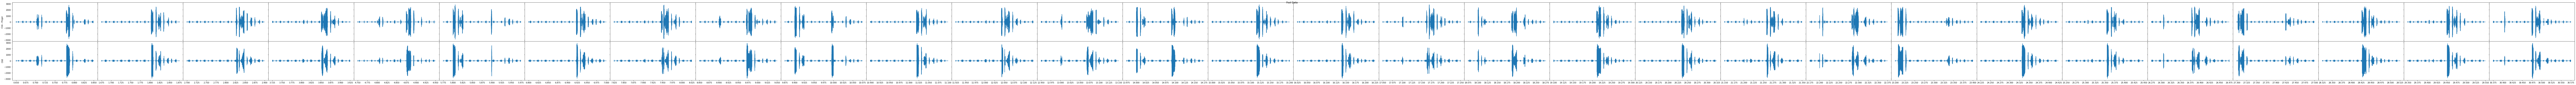

In [ ]:
bp_args={'fs': fs, 'low': 35e3, 'high':40e3}
bp = BP(**bp_args)
ma = MA(fs=fs, dt=3e-5)
get_win = lambda i: slice(int(fs*(i+0.65)), int(fs*(i+0.85)))
n = 30
f, axs = plt.subplots(2, n, sharex='col', sharey=True, figsize=(n * 6,6))
f.tight_layout()
for i, ax in enumerate(zip(*axs)):
    win = get_win(i*1.025)
    ax[0].plot(t[win], (bp(y[win,0])))
    ax[1].plot(t[win], (bp(y[win,1])))
    # ax[0].plot(t[win], ma(bp(y[win,0])))
    # ax[1].plot(t[win], ma(bp(y[win,1])))
f.subplots_adjust(wspace=0, hspace=0)

for i, ax in enumerate(zip(*axs)):
    ax[0].set_ylabel("ChA - Pinger")
    ax[1].set_ylabel("ChB")
    break
f.suptitle("Pool Data")
f.show()

## Deal w double pings

### Old ZC

In [ ]:
bp_args={'fs': fs, 'low': 35e3, 'high':40e3}
bp = BP(**bp_args)
ma = MA(fs=fs, dt=3e-5)
hil = Hilbert(fs=fs)

-0.05772 1.3394 0.98864 1.33052 3.27376 -0.00888 0.8806 1.5392 4.41632 -0.05476 1.36308 1.3542 -1.58508 0.0296 1.42672 1.332 0.09028 0.10064 1.3838 1.4134 87.59232 -0.00888 0.91464 1.3394 1.3764 -0.09028 1.28612 1.40156 1.3986 0.16132 

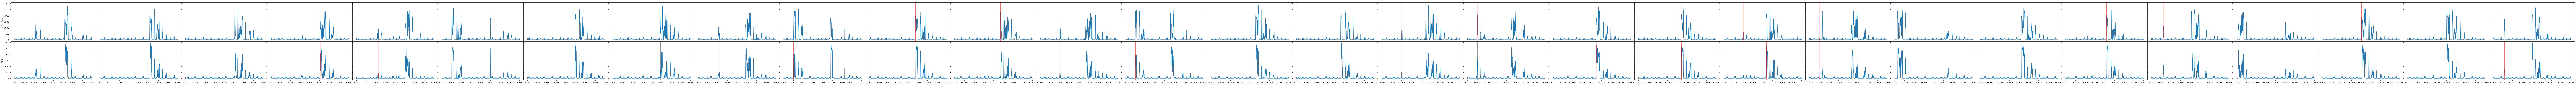

In [ ]:
get_win = lambda i: slice(int(fs*(i+0.65)), int(fs*(i+0.85)))
n = 30
f, axs = plt.subplots(2, n, sharex='col', sharey=True, figsize=(n * 6,6))
f.tight_layout()
for i, ax in enumerate(zip(*axs)):
    win = get_win(i*1.025)
    s1 = hil(bp(y[win,0]))
    s2 = hil(bp(y[win,1]))
    ax[0].plot(t[win], s1)
    ax[1].plot(t[win], s2)
    index = Est_ZC_stage_1(s1, int(0.004 * fs), 200, run_plot=False)
    if index !=0:
        ax[0].axvline(x=t[win][index], color='red', alpha=0.6, linewidth=1)
    
    index2 = Est_ZC_stage_1(s2, int(0.004 * fs), 200, run_plot=False)
    if index2 !=0:
        ax[1].axvline(x=t[win][index2], color='red', alpha=0.6, linewidth=1)
    if index != 0 and index2 != 0:
        print((index2-index)*v_sound / fs, end=' ')
    else:
        print(np.nan, end=' ')
    # ax[0].plot(t[win], ma(bp(y[win,0])))
    # ax[1].plot(t[win], ma(bp(y[win,1])))
f.subplots_adjust(wspace=0, hspace=0)

for i, ax in enumerate(zip(*axs)):
    ax[0].set_ylabel("ChA - Pinger")
    ax[1].set_ylabel("ChB")
    break
f.suptitle("Pool Data")
f.show()

### New ZC

In [ ]:
import itertools
import numpy as np


# TODO: how to deal with multiple sets of zero crossing,
# TODO: groupby can bre replaced my numpy indexing i think
# notes for function def stage_1(signal, winsize_zero_cross, fs, run_plot)
# stage 1 does the following processes:
# 1. filter use IIR bandpass filters
# 2. estimate the zero-crossing of the first peak in two stages
#    first of which is approximate position where first peak crosses the threshold of 10% of signal mean
#    second stage, wherein use curvature of the signal to estimate a more-accurate estimate of zero-crossing
# Availible defaults           500,1e6,                    0,
def get_zc_index(signal, winsize, std_noise_multiplier, run_plot=False, plot_title='zero_crossing'):
    def sum_index(index_limit, reshaped_group_results_len):
        ind_count = 0
        for k in range(0, index_limit):
            ind_count = ind_count + reshaped_group_results_len[k]
        return ind_count

    def ZC_estimation(signal_h, noise_threshold, n_max_p):

        # estimate out part of the signal which is > threshold
        results = np.where(signal_h > noise_threshold, True, False)

        # itertools groupby aims to group the array in groups of True and False
        # where g is the groups and k is unique key/ value in each group
        # size/ length of the groups is given by len(list(g)) and is stored as an np.array
        group_results_len = np.array([len(list(g)) for k, g in itertools.groupby(results)])

        # only the first value of each groups (True or False) is stored in this array - will now correspond to each group
        # for which length are estimated previously
        group_results_value = np.array([list(g)[0] for k, g in itertools.groupby(results)])

        # indices & group-length wherein corresponding value in group_results_value is True
        ind_of_group_results_value_for_trues = np.array(np.where(group_results_value == True))
        group_len_counts_of_true = (group_results_len[ind_of_group_results_value_for_trues])

        # indices of top n_max maximuma of group_len_counts_of_true
        ind_n_max_group_len_counts_of_true = np.array(np.argsort(-group_len_counts_of_true))

        # manipulations to match the shape of the arrays
        group_len_counts_of_true = group_len_counts_of_true.T
        ind_n_max_group_len_counts_of_true = ind_n_max_group_len_counts_of_true.T

        # how many maxs (top-n) need to be estimated?
        n_max = int(len(group_len_counts_of_true) * n_max_p / 100)
        if n_max <= 2:
            n_max = int(len(group_len_counts_of_true))

        ind_n_max_group_len_counts_of_true = np.array(ind_n_max_group_len_counts_of_true[0:n_max])

        # what are the values of the top-n (sorted) group-lengths of trues?
        values_maxes_in_group_results_len = np.array((group_len_counts_of_true[ind_n_max_group_len_counts_of_true]))
        values_maxes_in_group_results_len = np.reshape(values_maxes_in_group_results_len, (n_max, 1))

        # manipulations to match the shape of the arrays
        reshaped_group_results_len = np.reshape(group_results_len, (len(group_results_len), 1))

        # elementwise comparison of the arrays to estimate the starting indices of the n_max groups of True:
        # comparison with the entire (true-false) list
        ind_of_max_in_group_results_len = np.array(np.where(np.in1d(reshaped_group_results_len,
                                                                    values_maxes_in_group_results_len)))

        index_max_counts_of_true = np.zeros((len(ind_of_max_in_group_results_len), 1))
        for i in range(len(ind_of_max_in_group_results_len)):
            try:
                index_max_counts_of_true[i] = sum_index(ind_of_max_in_group_results_len[i, 0],
                                                        reshaped_group_results_len) + 1
            except:
                index_max_counts_of_true[i] = 0
                break

        Q_zero_cross_index = (np.min(index_max_counts_of_true[:, 0])).astype(int)

        return Q_zero_cross_index

    def plot_ZC(signal_h, Q_zero_cross_index, plot_title, winsize):
        import matplotlib.pyplot as plt
        from matplotlib.patches import Rectangle
        index = Q_zero_cross_index
        fig, axs = plt.subplots(1, figsize=(10,4))
        fig.suptitle(plot_title)
        axs.plot(signal_h, label='bandpass')
        axs.plot(np.repeat(0, len(signal_h)), 'k--', label='zero level')
        axs.plot(np.repeat(noise_threshold_1, len(signal_h)), 'r--', label='noise_threshold_1')
        axs.plot(np.repeat(noise_threshold_2, len(signal_h)), 'b--', label='noise_threshold_2')
        axs.plot(index, signal_h[index], 'o')
        rect = Rectangle((index, 0), winsize * 2, np.max(signal_h) / 2, linewidth=3, edgecolor='r', facecolor='none')
        axs.add_patch(rect)
        axs.legend()

    # filter first and then, normalise the signal for further processing
    # estimate the envelope of the rectified signal using the hilbert transform
    # estimate threshold
    threshold = (np.mean(signal))
    signal_noise_h = np.where(signal > threshold, 0, signal)
    noise_threshold_1 = np.mean(signal_noise_h) + std_noise_multiplier * np.std(signal_noise_h)
    # noise_threshold_1 = 200

    # first iteration
    n_max_p = 5
    init_est_ZC_index = ZC_estimation(signal, noise_threshold_1, n_max_p)
    # print(f'init_est_ZC_index - {plot_title}', init_est_ZC_index)

    # attempt to check the samples in the neighbourhood
    hori_check_indices = np.linspace(max(init_est_ZC_index - winsize,0), min(init_est_ZC_index + winsize,signal.shape[0] - 1), winsize * 2, dtype=int)
    if np.all(signal[hori_check_indices] < 10 * noise_threshold_1):
        init_est_ZC_index = ZC_estimation(signal, noise_threshold_1 * 2, n_max_p)

    # attempt to check the samples in the neighbourhood by selecting a window with elevated threshold
    noise_threshold_2 = noise_threshold_1 * 1.25
    # print('noise_threshold_2', noise_threshold_2)
    second_est_ZC_index = 0
    if signal[init_est_ZC_index] >= 3 * noise_threshold_1:
        # second iteration
        n_max_p = 50
        sub_signal = signal[init_est_ZC_index - winsize: init_est_ZC_index + winsize]
        ZC_subsignal = ZC_estimation(sub_signal, noise_threshold_2, n_max_p)
        # print(f'ZC_subsignal - {plot_title}', ZC_subsignal)
        second_est_ZC_index = init_est_ZC_index + (ZC_subsignal - winsize)
        # print(f'second_est_ZC_index - {plot_title}', second_est_ZC_index)

    if second_est_ZC_index != 0:
        ZC_index = second_est_ZC_index
    else:
        ZC_index = init_est_ZC_index

    if run_plot:
        plot_ZC(signal, ZC_index, plot_title, winsize)

    return ZC_index


### Visual New ZC

In [ ]:
dist = 0.65
t, y = data_loader[dist, 0]
bp_args={'fs': fs, 'low': 35e3, 'high':40e3}
bp = BP(**bp_args)
ma = MA(fs=fs, dt=3e-5)
hil = Hilbert(fs=fs)

In [ ]:
get_win = lambda i: slice(int(fs*(i+0.65)), int(fs*(i+0.85)))
win = get_win(7*1.025)
ttt = t[win]
sig = hil(bp(y[win,1]))
win = get_win(9*1.025)
ttt2 = t[win]
sig2 = hil(bp(y[win,0]))

In [ ]:
real_zero = 50
max_break_time = 0.0005
min_peak_time = 2e-3
min_peak_height = 1500
min_time_b_w_peaks = 0.9

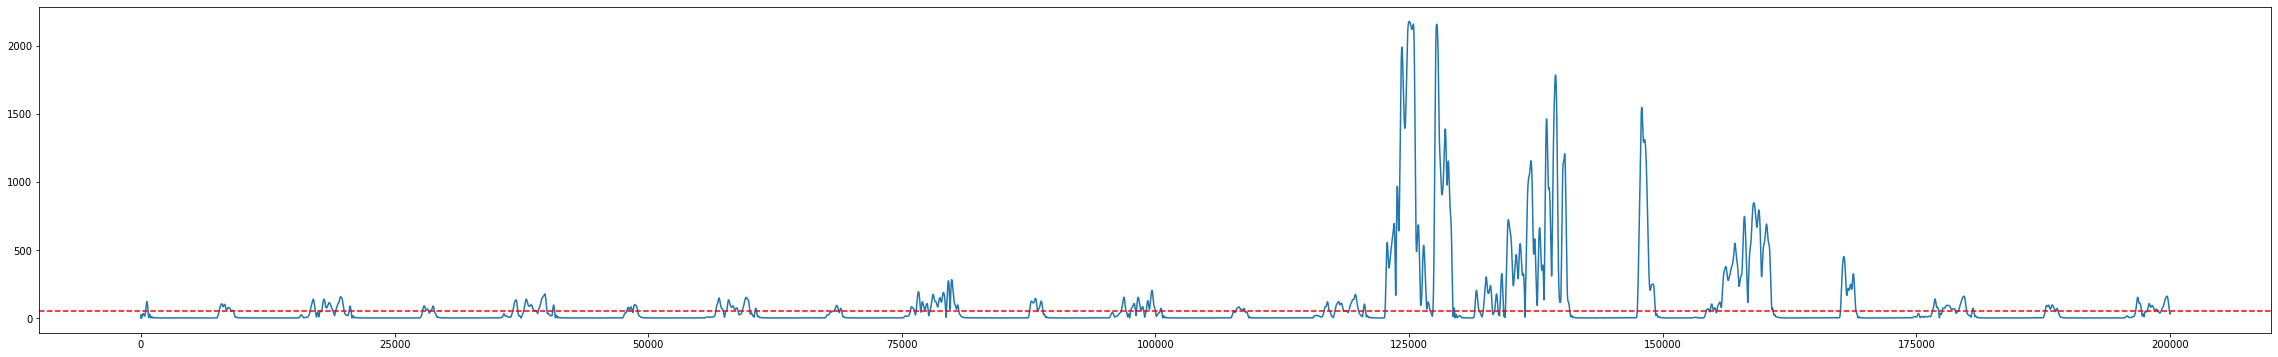

In [ ]:
plt.figure(figsize=(40,6))
plt.plot(sig)
plt.axhline(y=real_zero, linestyle='--', color='red')

In [ ]:
x = sig.copy()

# Ensure no range crosses the boundary
x[0] = 0
x[-1] = 0

sig_mask = sig > real_zero
start_index = np.where(np.diff(sig_mask.astype(int)) > 0)[0]
end_index = np.where(np.diff(sig_mask.astype(int)) < 0)[0]

In [ ]:
for index in np.where((start_index[1:] - end_index[:-1]) < fs * max_break_time)[0][::-1]:
    start_index = np.delete(start_index, index + 1)
    end_index = np.delete(end_index, index)

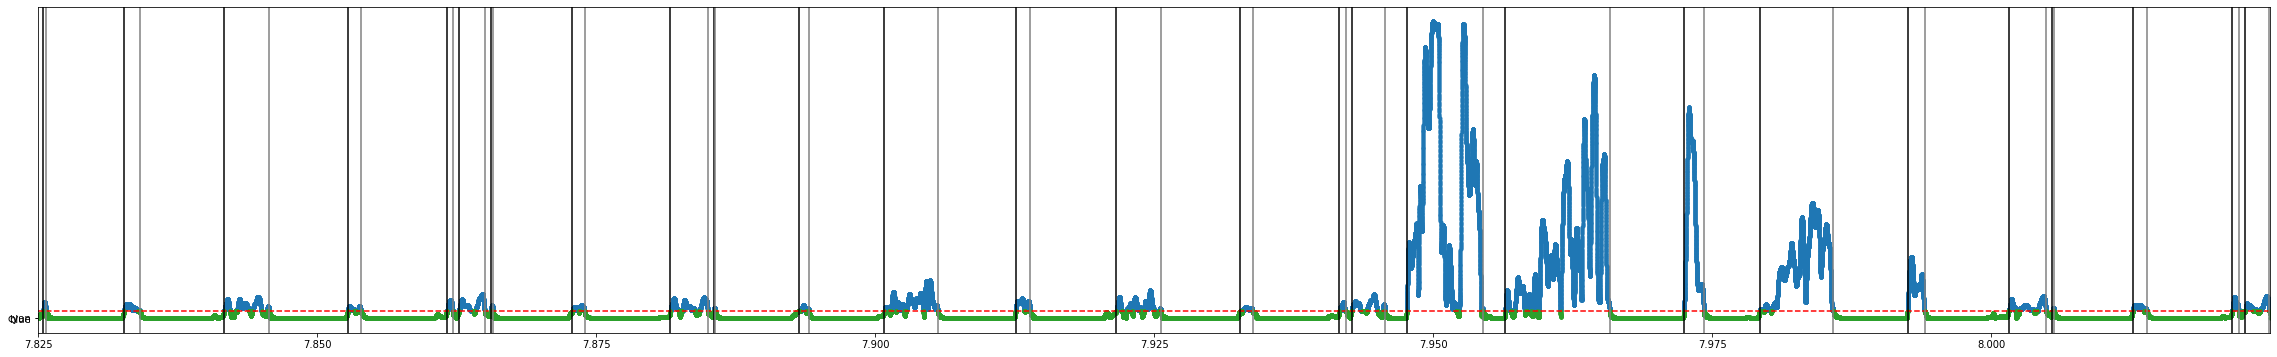

In [ ]:
plt.figure(figsize=(40,6))
plt.plot(ttt[sig_mask], x[sig_mask], '.', 'blue')
plt.plot(ttt[~sig_mask], x[~sig_mask], '.', 'cyan')
plt.xlim(ttt[0], ttt[-1])
plt.axhline(y=real_zero, linestyle='--', color='red')
for i in start_index:
    plt.axvline(ttt[i], color='black')
for i in end_index:
    plt.axvline(ttt[i], color='gray')

In [ ]:
wide_enough_peaks = (end_index - start_index) > fs * min_peak_time
start_index, end_index = start_index[wide_enough_peaks], end_index[wide_enough_peaks]

In [ ]:
tall_enough_peaks = [True if x[slice(*r)].max() > min_peak_height else False for r in zip(start_index, end_index)] 
start_index, end_index = start_index[tall_enough_peaks], end_index[tall_enough_peaks]

In [ ]:
prev_in = -np.inf
i = 0
while i < len(start_index):
    if (start_index[i] - prev_in) > fs * min_time_b_w_peaks:
        prev_in = start_index[i]
        i += 1
    else:
        start_index = np.delete(start_index, i)
        end_index = np.delete(end_index, i)

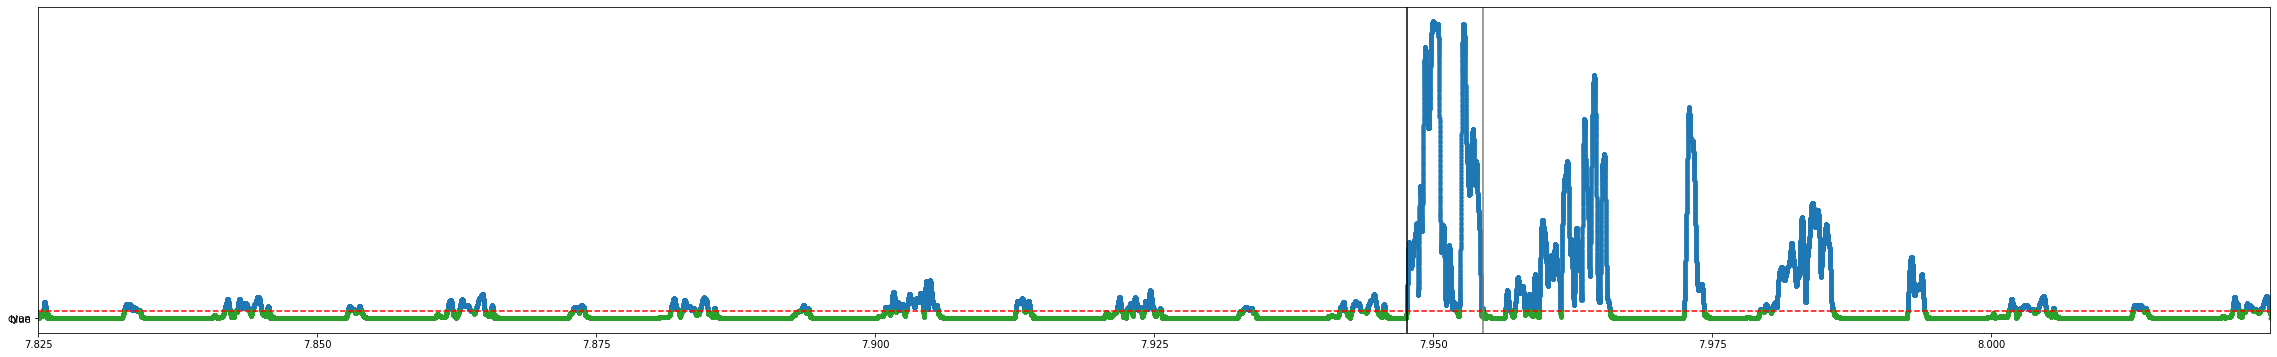

In [ ]:
plt.figure(figsize=(40,6))
plt.plot(ttt[sig_mask], x[sig_mask], '.', 'blue')
plt.plot(ttt[~sig_mask], x[~sig_mask], '.', 'cyan')
plt.xlim(ttt[0], ttt[-1])
plt.axhline(y=real_zero, linestyle='--', color='red')
for i in start_index:
    plt.axvline(ttt[i], color='black')
for i in end_index:
    plt.axvline(ttt[i], color='gray')

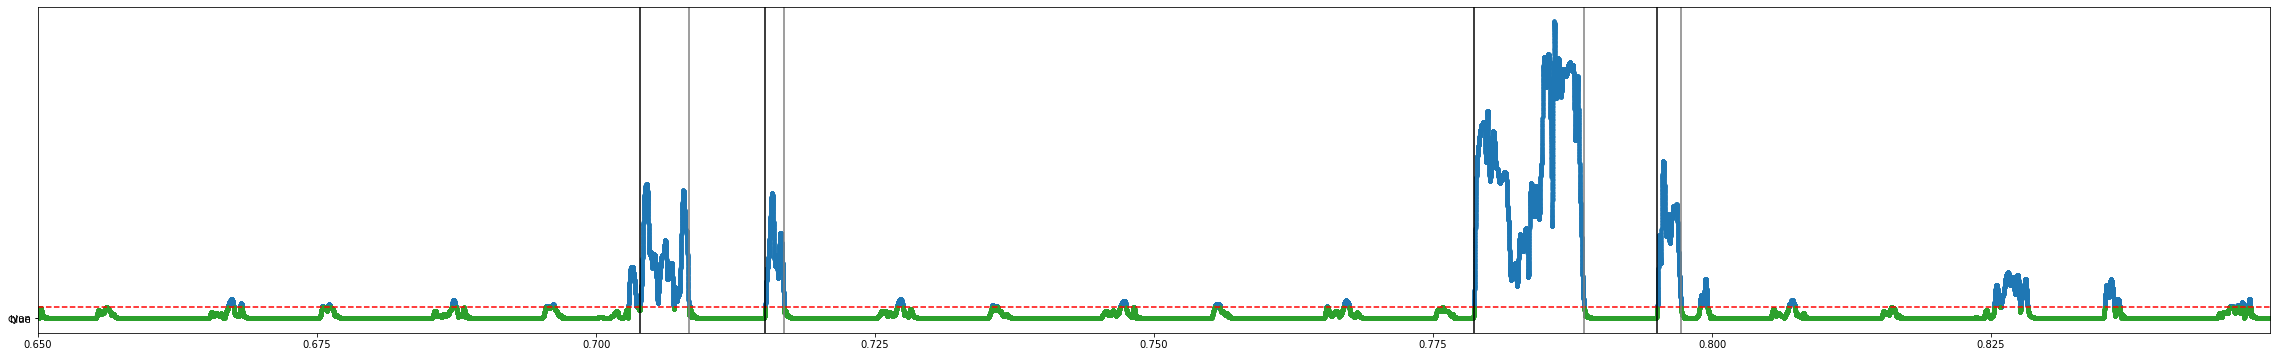

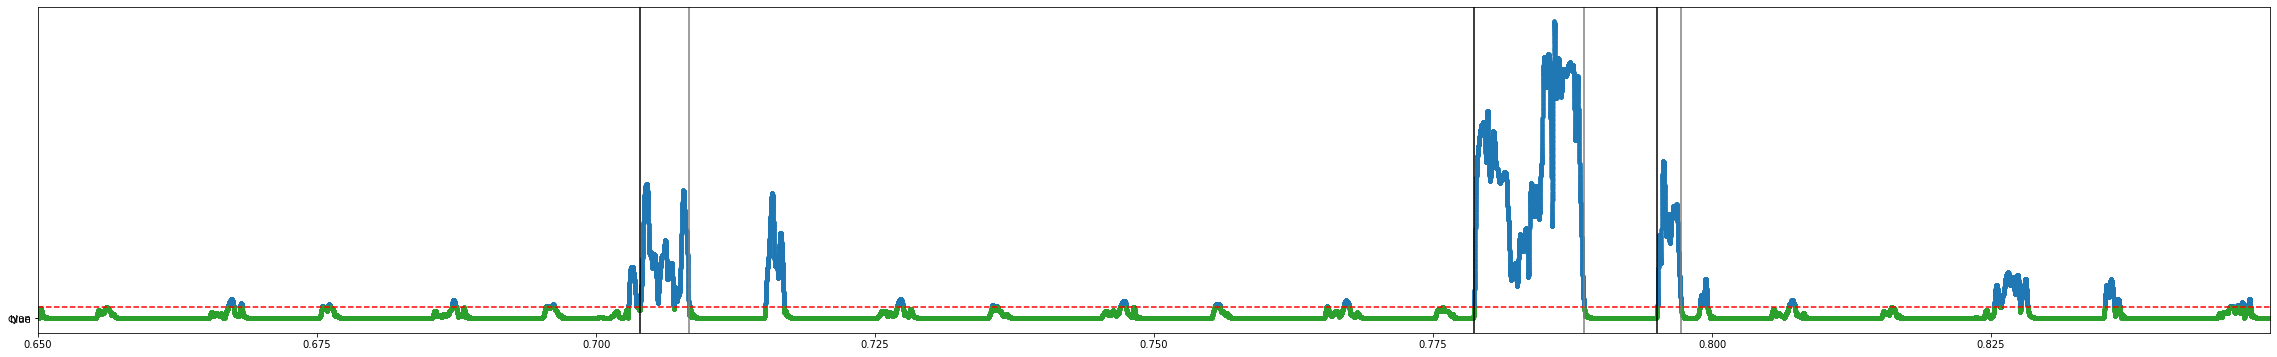

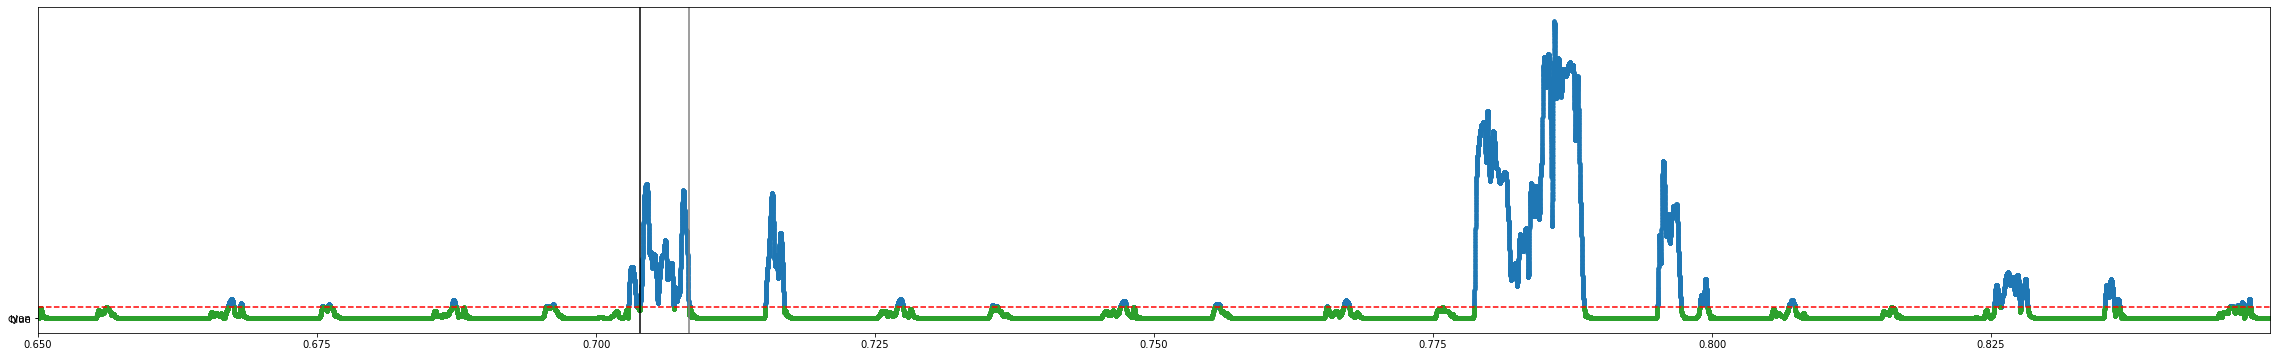

In [ ]:
viz(0)

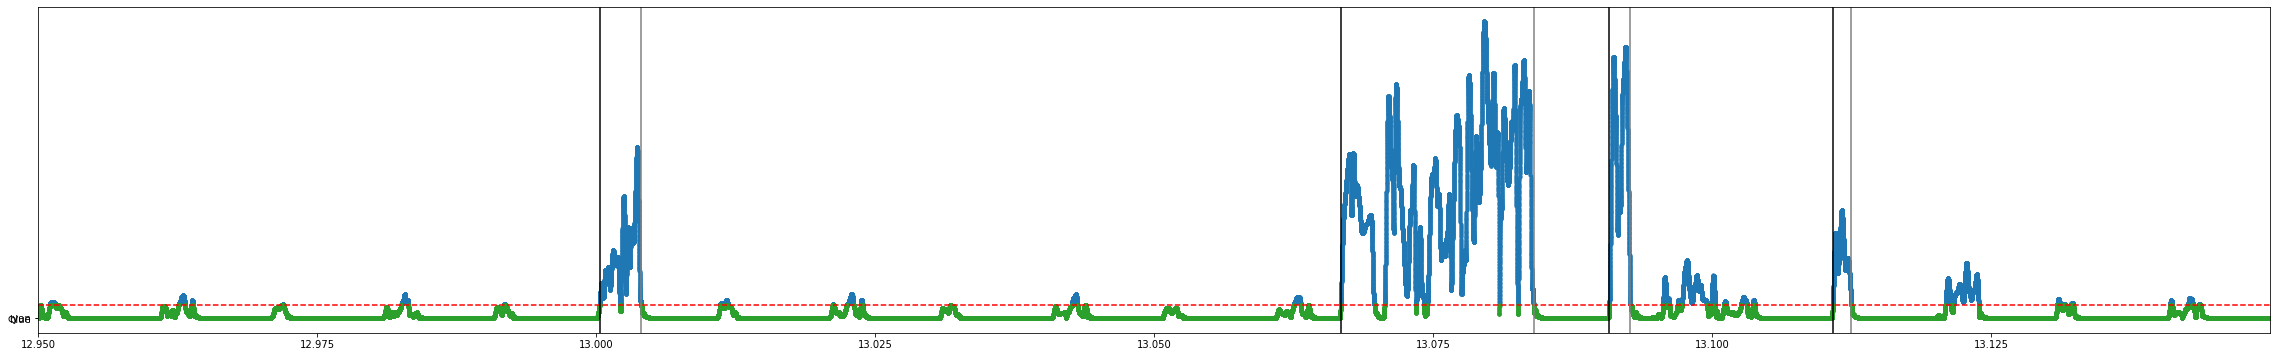

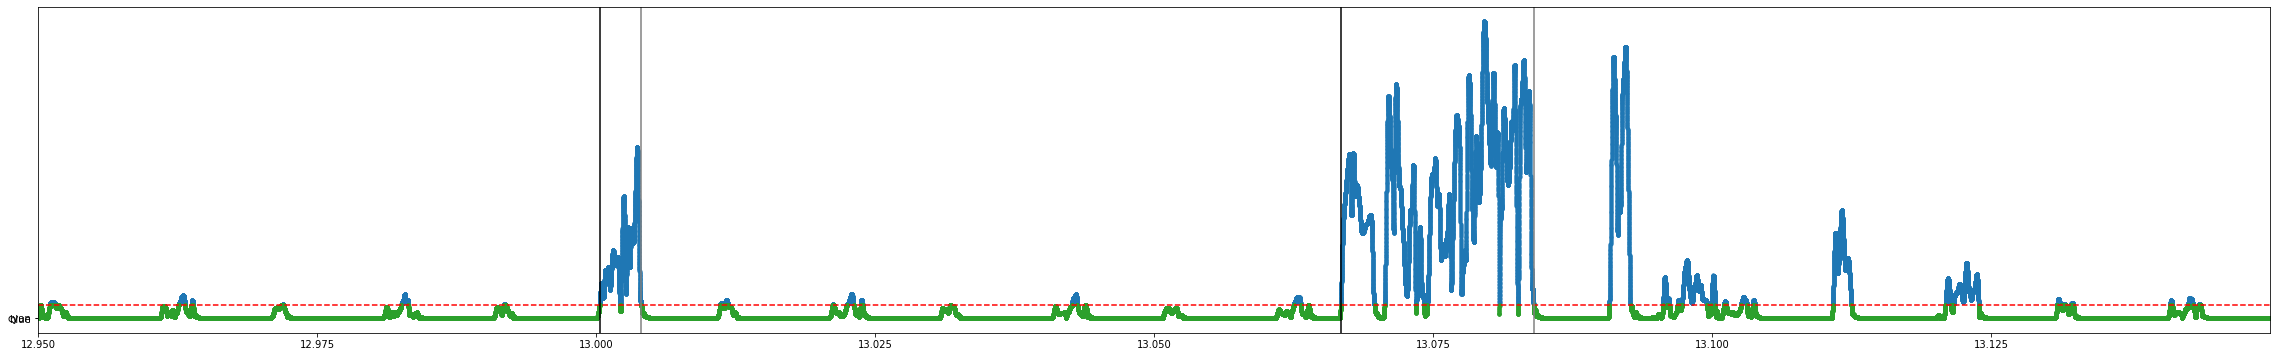

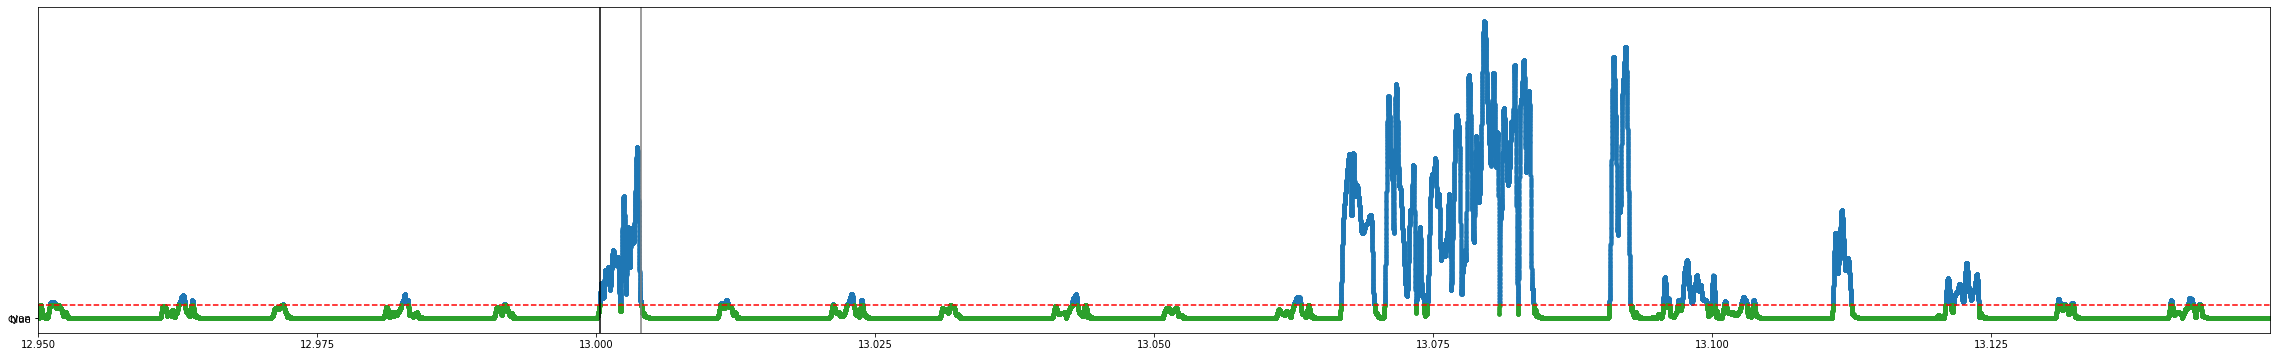

In [ ]:
viz(12)

In [ ]:
def viz(i):
    dist = 0.65
    t, y = data_loader[dist, 0]
    bp_args={'fs': fs, 'low': 35e3, 'high':40e3}
    bp = BP(**bp_args)
    ma = MA(fs=fs, dt=3e-5)
    hil = Hilbert(fs=fs)

    get_win = lambda i: slice(int(fs*(i+0.65)), int(fs*(i+0.85)))
    win = get_win(i*1.025)
    ttt = t[win]
    sig = hil(bp(y[win,0]))

    real_zero = 100
    max_break_time = 0.001
    min_peak_time = 2e-3
    init_min_peak_height = 500
    min_peak_height = 1500
    min_time_b_w_peaks = 0.9

    # plt.figure(figsize=(40,6))
    # plt.plot(sig)
    # plt.axhline(y=real_zero, linestyle='--', color='red')

    x = sig.copy()

    # Ensure no range crosses the boundary
    x[0] = 0
    x[-1] = 0

    sig_mask = sig > real_zero
    start_index = np.where(np.diff(sig_mask.astype(int)) > 0)[0]
    end_index = np.where(np.diff(sig_mask.astype(int)) < 0)[0]


    tall_enough_peaks = [True if x[slice(*r)].max() > init_min_peak_height else False for r in zip(start_index, end_index)] 
    start_index, end_index = start_index[tall_enough_peaks], end_index[tall_enough_peaks]


    for index in np.where((start_index[1:] - end_index[:-1]) < fs * max_break_time)[0][::-1]:
        start_index = np.delete(start_index, index + 1)
        end_index = np.delete(end_index, index)

    plt.figure(figsize=(40,6))
    plt.plot(ttt[sig_mask], x[sig_mask], '.', 'blue')
    plt.plot(ttt[~sig_mask], x[~sig_mask], '.', 'cyan')
    plt.xlim(ttt[0], ttt[-1])
    plt.axhline(y=real_zero, linestyle='--', color='red')
    for i in start_index:
        plt.axvline(ttt[i], color='black')
    for i in end_index:
        plt.axvline(ttt[i], color='gray')

    wide_enough_peaks = (end_index - start_index) > fs * min_peak_time
    start_index, end_index = start_index[wide_enough_peaks], end_index[wide_enough_peaks]
    
    tall_enough_peaks = [True if x[slice(*r)].max() > min_peak_height else False for r in zip(start_index, end_index)] 
    start_index, end_index = start_index[tall_enough_peaks], end_index[tall_enough_peaks]

    plt.figure(figsize=(40,6))
    plt.plot(ttt[sig_mask], x[sig_mask], '.', 'blue')
    plt.plot(ttt[~sig_mask], x[~sig_mask], '.', 'cyan')
    plt.xlim(ttt[0], ttt[-1])
    plt.axhline(y=real_zero, linestyle='--', color='red')
    for i in start_index:
        plt.axvline(ttt[i], color='black')
    for i in end_index:
        plt.axvline(ttt[i], color='gray')

    prev_in = -np.inf
    i = 0
    while i < len(start_index):
        if (start_index[i] - prev_in) > fs * min_time_b_w_peaks:
            prev_in = start_index[i]
            i += 1
        else:
            start_index = np.delete(start_index, i)
            end_index = np.delete(end_index, i)

    plt.figure(figsize=(40,6))
    plt.plot(ttt[sig_mask], x[sig_mask], '.', 'blue')
    plt.plot(ttt[~sig_mask], x[~sig_mask], '.', 'cyan')
    plt.xlim(ttt[0], ttt[-1])
    plt.axhline(y=real_zero, linestyle='--', color='red')
    for i in start_index:
        plt.axvline(ttt[i], color='black')
    for i in end_index:
        plt.axvline(ttt[i], color='gray')

In [ ]:
def get_zero_crossing(sig,
                      real_zero=100,
                      max_break_time=0.001,
                      min_peak_time=2e-3,
                      init_min_peak_height=500,
                      min_peak_height=1500,
                      min_time_b_w_peaks=0.9,
                      plot=False):
    x = sig.copy()

    # Ensure no range crosses the boundary
    x[0] = 0
    x[-1] = 0

    sig_mask = x > real_zero
    start_index = np.where(np.diff(sig_mask.astype(int)) > 0)[0]
    end_index = np.where(np.diff(sig_mask.astype(int)) < 0)[0]

    tall_enough_peaks = [True if x[slice(*r)].max() > init_min_peak_height else False for r in
                         zip(start_index, end_index)]
    start_index, end_index = start_index[tall_enough_peaks], end_index[tall_enough_peaks]

    for index in np.where((start_index[1:] - end_index[:-1]) < fs * max_break_time)[0][::-1]:
        start_index = np.delete(start_index, index + 1)
        end_index = np.delete(end_index, index)

    if plot:
        plt.figure(figsize=(40, 6))
        plt.plot(ttt[sig_mask], x[sig_mask], '.', 'blue')
        plt.plot(ttt[~sig_mask], x[~sig_mask], '.', 'cyan')
        plt.xlim(ttt[0], ttt[-1])
        plt.axhline(y=real_zero, linestyle='--', color='red')
        for i in start_index:
            plt.axvline(ttt[i], color='black')
        for i in end_index:
            plt.axvline(ttt[i], color='gray')

    wide_enough_peaks = (end_index - start_index) > fs * min_peak_time
    start_index, end_index = start_index[wide_enough_peaks], end_index[wide_enough_peaks]

    tall_enough_peaks = [True if x[slice(*r)].max() > min_peak_height else False for r in zip(start_index, end_index)]
    start_index, end_index = start_index[tall_enough_peaks], end_index[tall_enough_peaks]

    if plot:
        plt.figure(figsize=(40, 6))
        plt.plot(ttt[sig_mask], x[sig_mask], '.', 'blue')
        plt.plot(ttt[~sig_mask], x[~sig_mask], '.', 'cyan')
        plt.xlim(ttt[0], ttt[-1])
        plt.axhline(y=real_zero, linestyle='--', color='red')
        for i in start_index:
            plt.axvline(ttt[i], color='black')
        for i in end_index:
            plt.axvline(ttt[i], color='gray')

    prev_in = -np.inf
    i = 0
    while i < len(start_index):
        if (start_index[i] - prev_in) > fs * min_time_b_w_peaks:
            prev_in = start_index[i]
            i += 1
        else:
            start_index = np.delete(start_index, i)
            end_index = np.delete(end_index, i)

    if plot:
        plt.figure(figsize=(40, 6))
        plt.plot(ttt[sig_mask], x[sig_mask], '.', 'blue')
        plt.plot(ttt[~sig_mask], x[~sig_mask], '.', 'cyan')
        plt.xlim(ttt[0], ttt[-1])
        plt.axhline(y=real_zero, linestyle='--', color='red')
        for i in start_index:
            plt.axvline(ttt[i], color='black')
        for i in end_index:
            plt.axvline(ttt[i], color='gray')

    return start_index, end_index - start_index


### Whole signal

In [ ]:
0.65 / v_sound * fs

439.1891891891892

In [ ]:
dist = 0.65
t, y = data_loader[dist, 0]

bp = BP(**{'fs': fs, 'low': 35e3, 'high':40e3})
ma = MA(fs=fs, dt=3e-5)
hil = Hilbert(fs=fs)

y0 = hil(bp(y[:,0]))
y1 = hil(bp(y[:,1]))

In [ ]:
ind_0, _ = get_zero_crossing(y0)
ind_1, _ = get_zero_crossing(y1)

In [ ]:
(ind_1 - ind_0)

array([  930,   936,   961,   915,  1036,    -4,   504,  1011,   915,
         -23,   958,   778,   885,    14,   968,   907,  1022,    38,
         978,   961,   608, -3645,   519,   951,   670,  1016,   919,
         991,   960,   611, -3428,   783,   937,   946,  -279,   906,
        1010,   960,  7816, -4094,   850,   930,   953,  1185,   915])

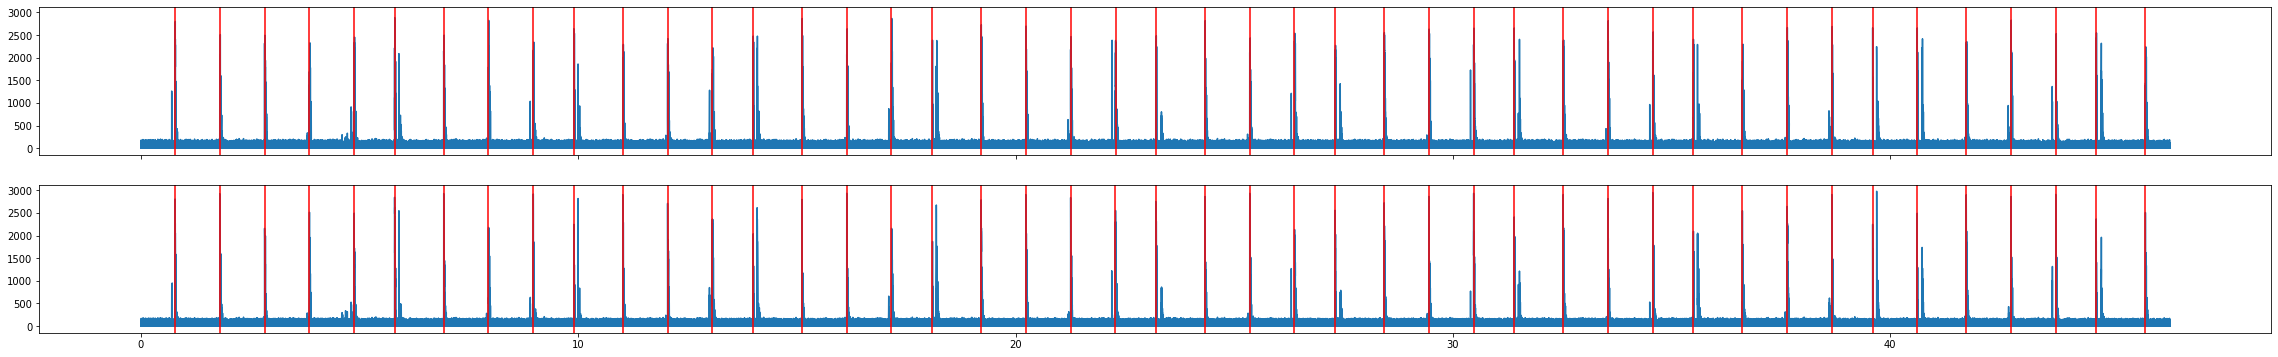

In [ ]:
f, ax = plt.subplots(2, 1, figsize=(40,6), sharex=True, sharey=True)

for a, y, index in zip(ax, (y0, y1,), (ind_0, ind_1,)):
    a.plot(t, y)
    for i in index:
        a.axvline(x=t[i], color='red')

## With Old Zero Crossing

In [ ]:
def view_pings(bt, bdata, start=0.25):
    bp_args={'fs': fs, 'low': 35e3, 'high': 40e3}
    bp = BP(**bp_args)
    get_win = lambda i: slice(int(fs*(i+start)), int(fs*(i+start + 0.6)))
    f, axs = plt.subplots(2, 10, sharex='col', sharey=True, figsize=(40,6))
    f.tight_layout()
    for i, ax in enumerate(zip(*axs)):
        win = get_win(i)
        d = bp(bdata[win,0])
        ax[0].plot(bt[win], d)
        index = Est_ZC_stage_1(d, int(0.004 * fs), 200, run_plot=False)
        if index !=0:
            ax[0].axvline(x=bt[win][index], color='red', alpha=0.6, linewidth=2)
        
        d = bp(bdata[win,1])
        ax[1].plot(bt[win], d)
        index2 = Est_ZC_stage_1(d, int(0.004 * fs), 200, run_plot=False)
        if index2 !=0:
            ax[1].axvline(x=bt[win][index2], color='red', alpha=0.6, linewidth=2)
        
        if index != 0 and index2 != 0:
            print((index2 - index) * v_sound / fs, end=' ')
        else:
            print(np.nan, end=' ')

    f.subplots_adjust(wspace=0, hspace=0)

0.01184 0.01184 0.01184 0.01036 -0.0666 0.01184 0.01184 0.01036 0.01184 0.01036 

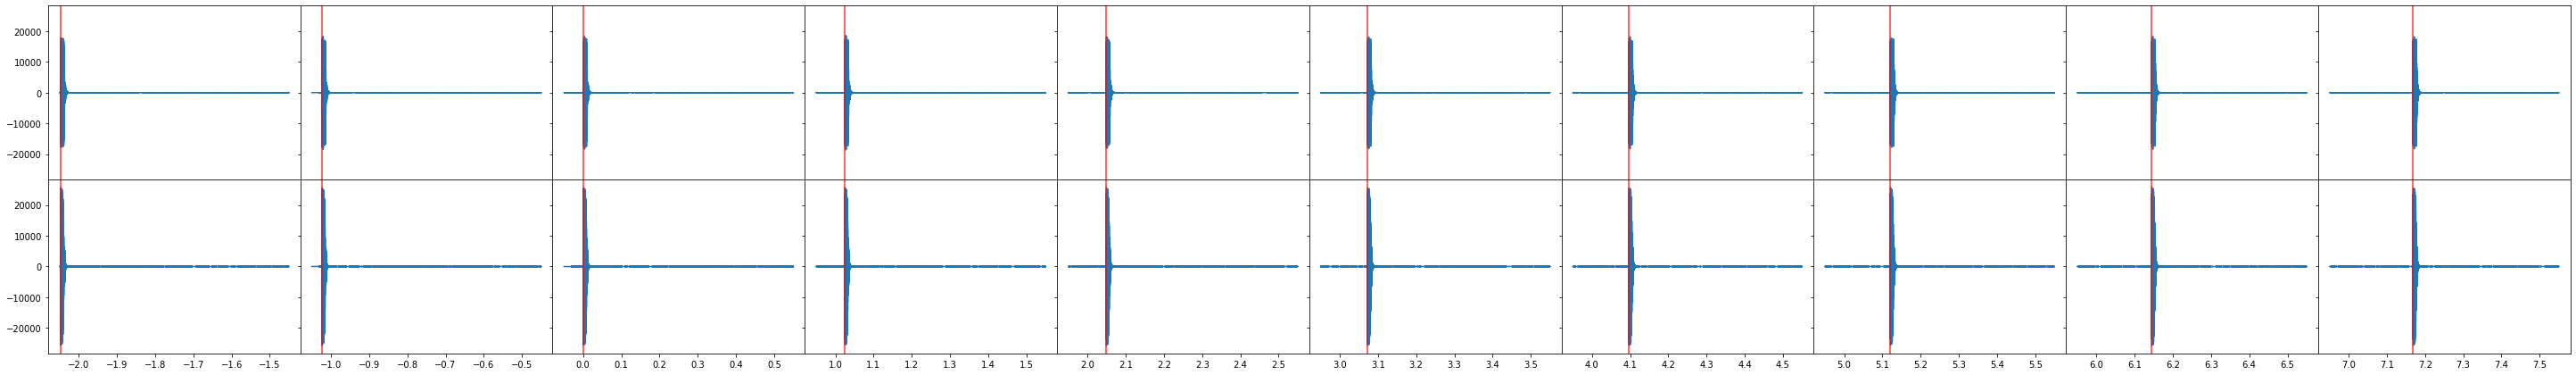

In [ ]:
view_pings(bt, bdata)

1.38084 1.26392 1.4208 1.94028 2.13564 0.0888 1.49628 2.53672 1.5022 -0.50468 

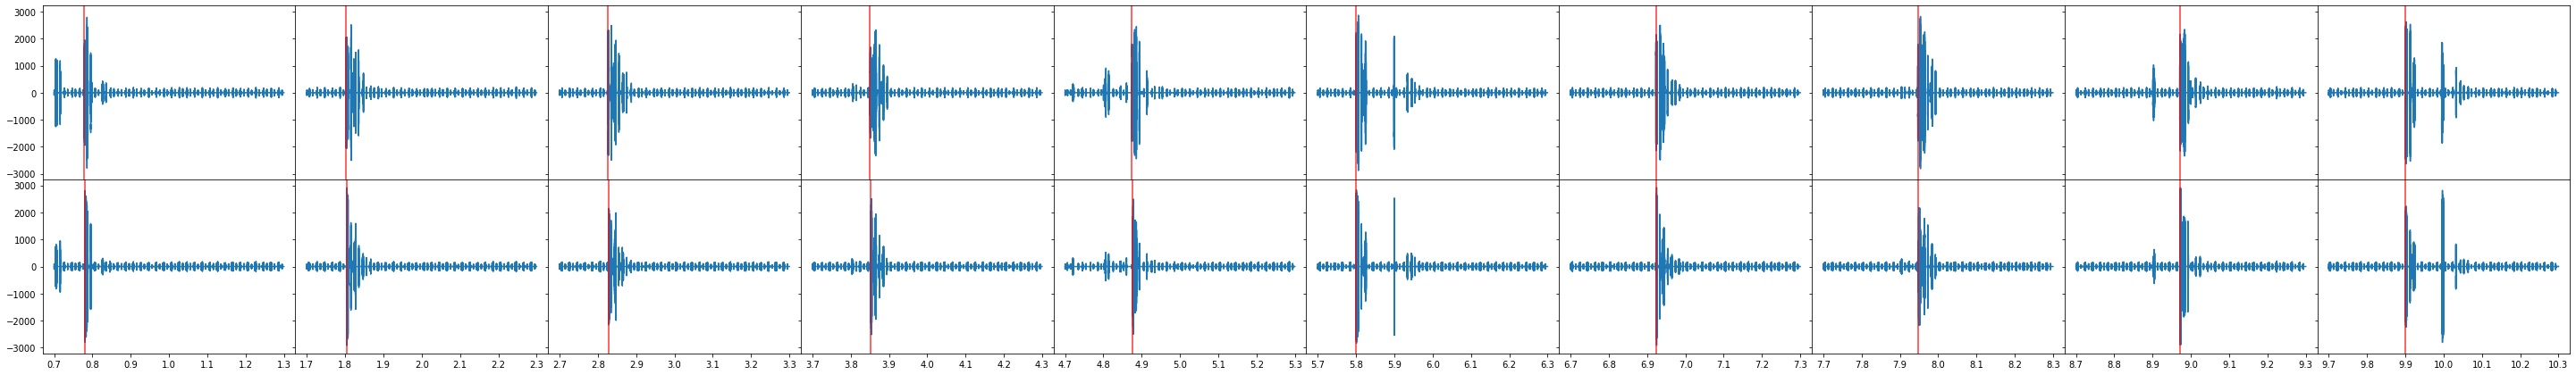

In [ ]:
view_pings(*data_loader[0.65, 0], start=0.7)

d065_2:   0%|          | 0/592 [00:00<?, ?it/s]

Got 591 chunks of 592 expected
1.66056 -2.02168 1.46076 1.4208 1.38084 0.27232 1.46076 1.46076 1.38232 -0.10656 

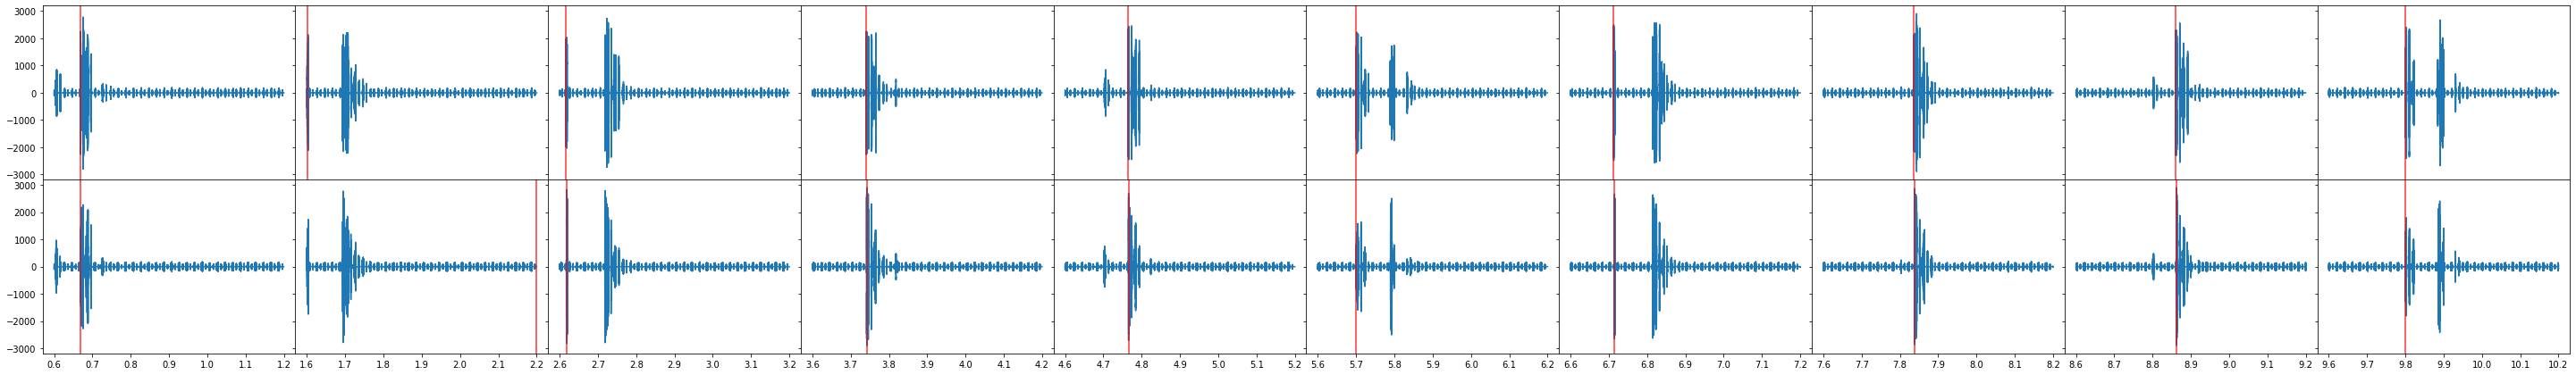

In [ ]:
view_pings(*data_loader[0.65, 1], start=0.6)

d000_1:   0%|          | 0/166 [00:00<?, ?it/s]

Got 165 chunks of 166 expected
0.39664 -4.25796 -0.37296 -0.65416 0.20424 0.2442 -6.35512 -1.45484 0.27972 0.24272 

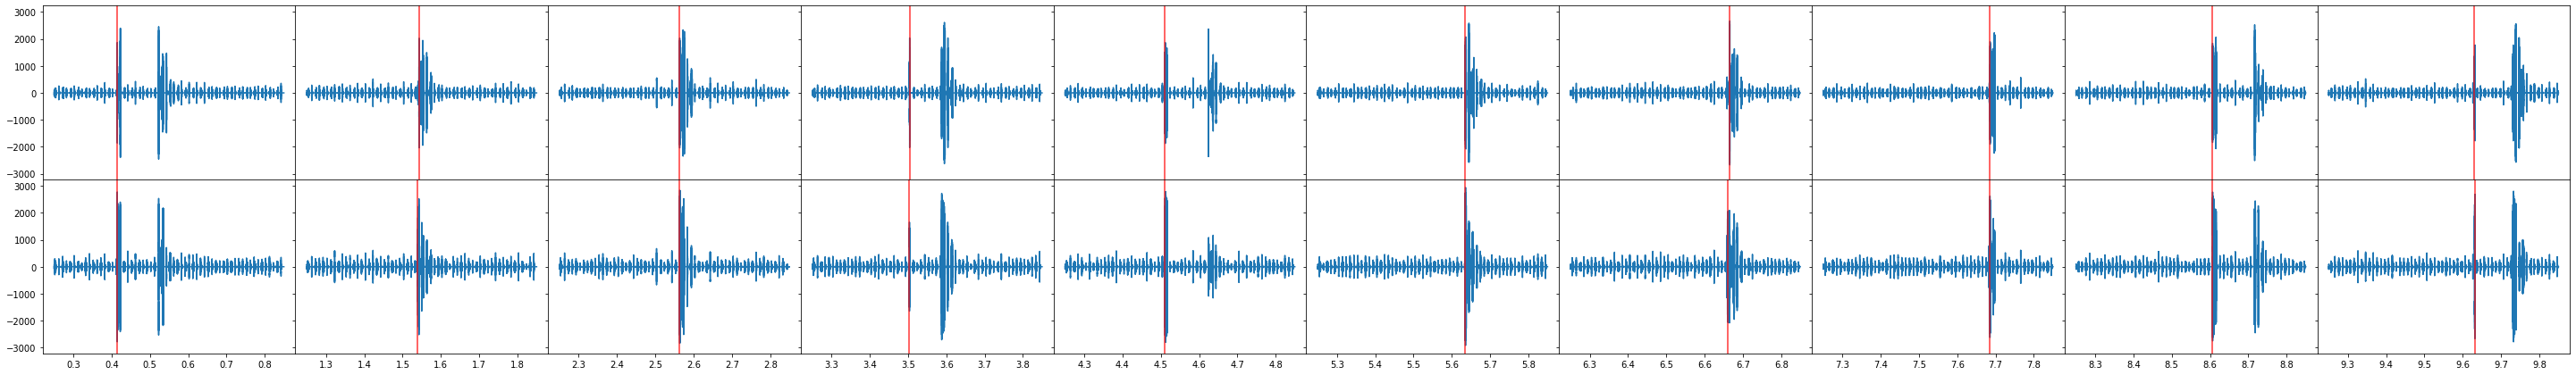

In [ ]:
view_pings(*data_loader[0.00, 0], start=0.25)

d000_2:   0%|          | 0/507 [00:00<?, ?it/s]

Got 506 chunks of 507 expected
-6.02064 1.03304 0.67784 0.46028 1.98616 1.40896 0.55944 0.55944 0.21312 15.45564 

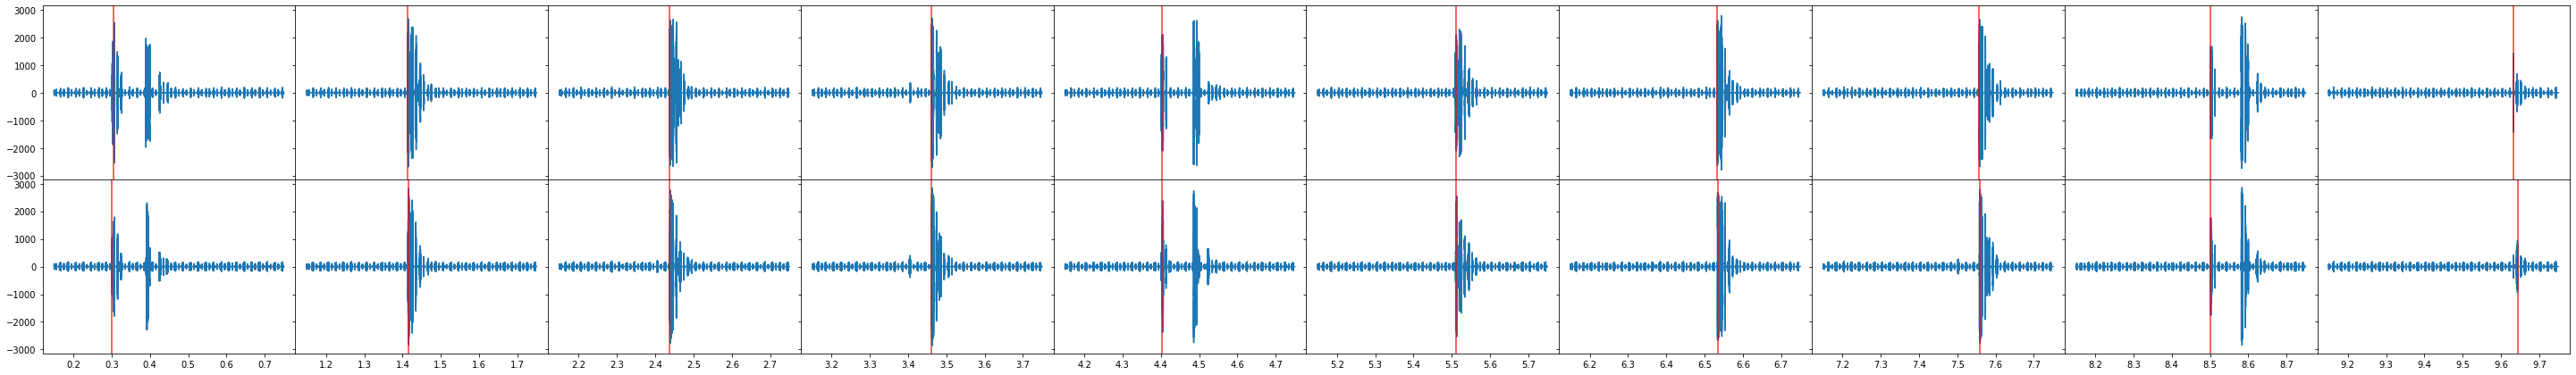

In [ ]:
view_pings(*data_loader[0.00, 1], start=0.15)

d125_1:   0%|          | 0/473 [00:00<?, ?it/s]

Got 472 chunks of 473 expected
4.21208 -0.24124 154.512 4.13068 4.45332 4.21208 3.00736 4.61168 4.49624 3.40548 

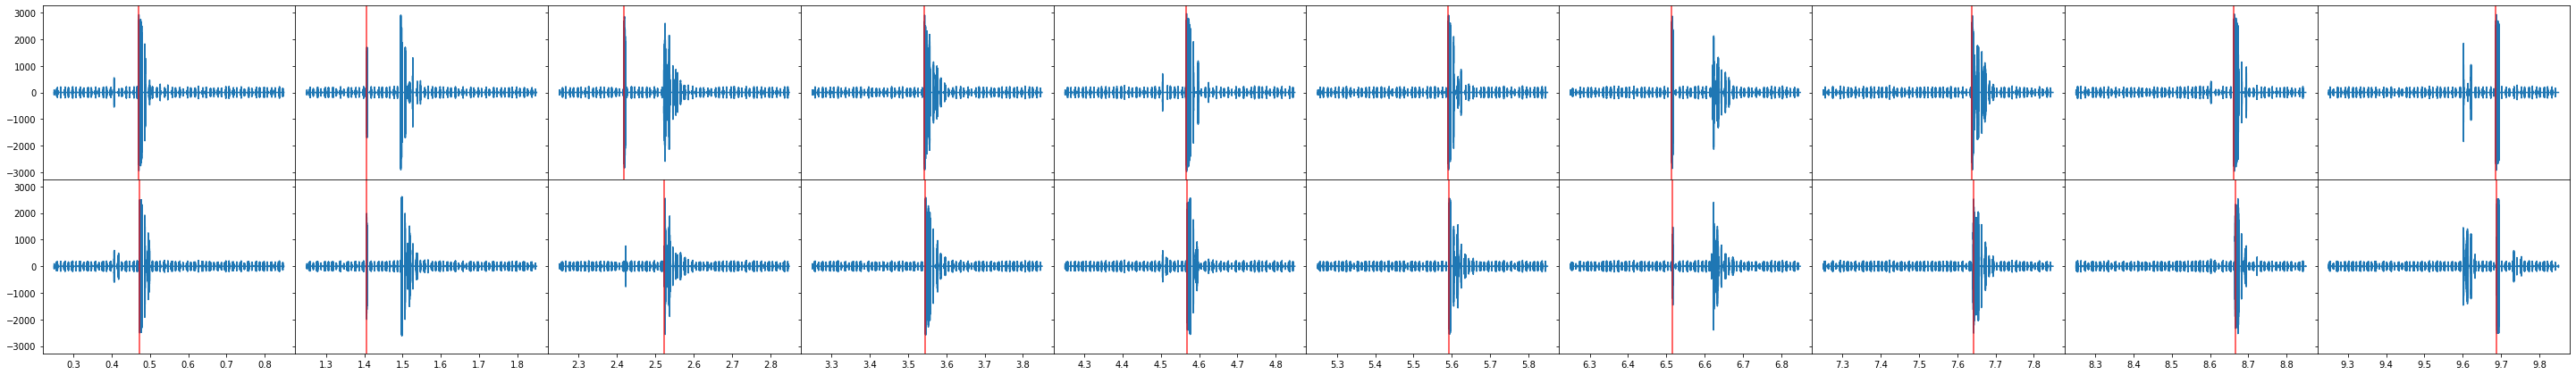

In [ ]:
view_pings(*data_loader[1.25, 0], start=0.25)

d125_2:   0%|          | 0/516 [00:00<?, ?it/s]

Got 515 chunks of 516 expected
-111.75924 208.84428 8.5544 2.92744 4.255 -0.29156 3.04732 8.95696 3.16424 0.26048 

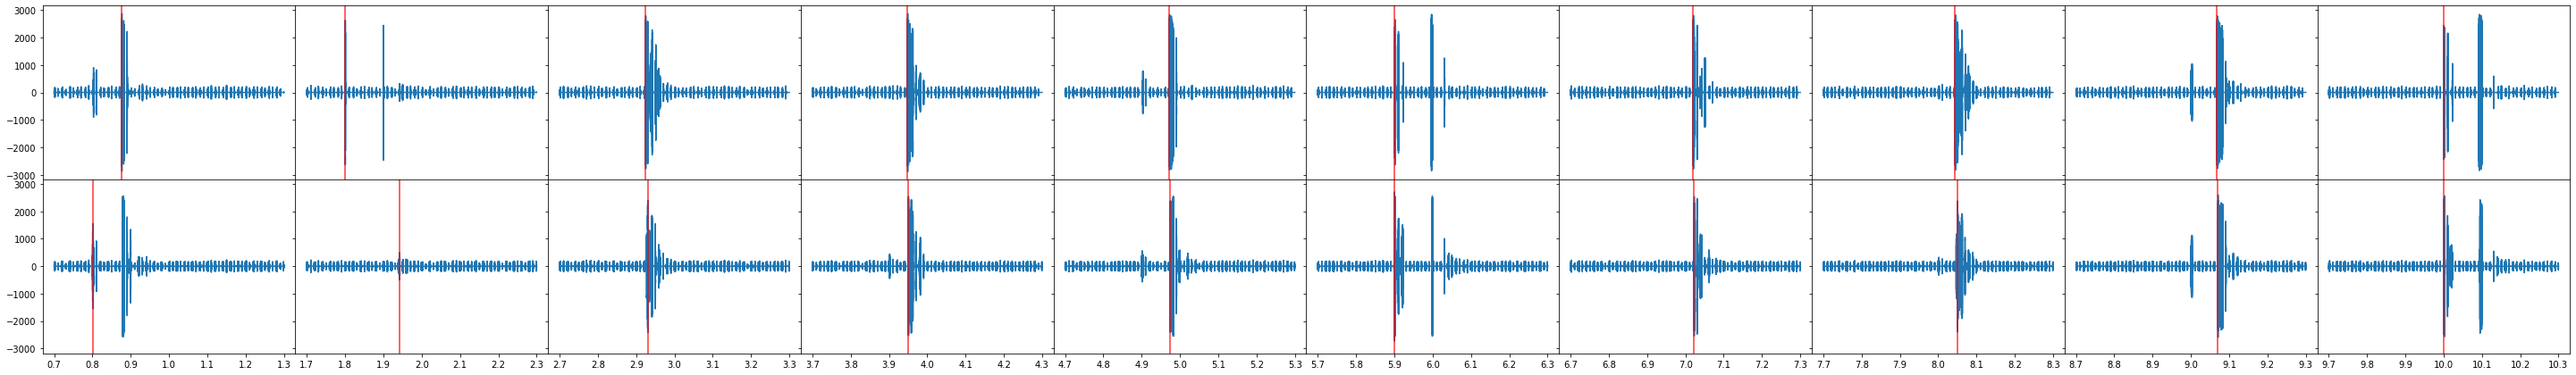

In [ ]:
view_pings(*data_loader[1.25, 1], start=0.7)

## With New ZC

In [ ]:
def view_new_pings(bt, bdata, start=0.25):
    bp_args={'fs': fs, 'low': 35e3, 'high': 40e3}
    bp = BP(**bp_args)
    ma = MA(fs=fs, dt=3e-5)
    hil = Hilbert(fs=fs)
    get_win = lambda i: slice(int(fs*(i+start)), int(fs*(i+start + 0.6)))
    f, axs = plt.subplots(2, 10, sharex='col', sharey=True, figsize=(40,6))
    f.tight_layout()
    for i, ax in enumerate(zip(*axs)):
        win = get_win(i)
        d = hil(bp(bdata[win,0]))
        ax[0].plot(bt[win], d)
        index, _= get_zero_crossing(d)
        if len(index) == 1:
            index = index[0]
        else:
            index = 0
        if index !=0:
            ax[0].axvline(x=bt[win][index], color='red', alpha=0.6, linewidth=2)
        
        d = hil(bp(bdata[win,1]))
        ax[1].plot(bt[win], d)
        index2, _ = get_zero_crossing(d)
        if len(index2) == 1:
            index2 = index2[0]
        else:
            index2 = 0
        if index2 !=0:
            ax[1].axvline(x=bt[win][index2], color='red', alpha=0.6, linewidth=2)
        
        if index != 0 and index2 != 0:
            print((index2 - index) * v_sound / fs, end=' ')
        else:
            print(np.nan, end=' ')

    f.subplots_adjust(wspace=0, hspace=0)

1.3764 1.38528 1.42228 1.3542 1.53328 -0.00592 0.74592 1.49628 1.3542 -0.03404 

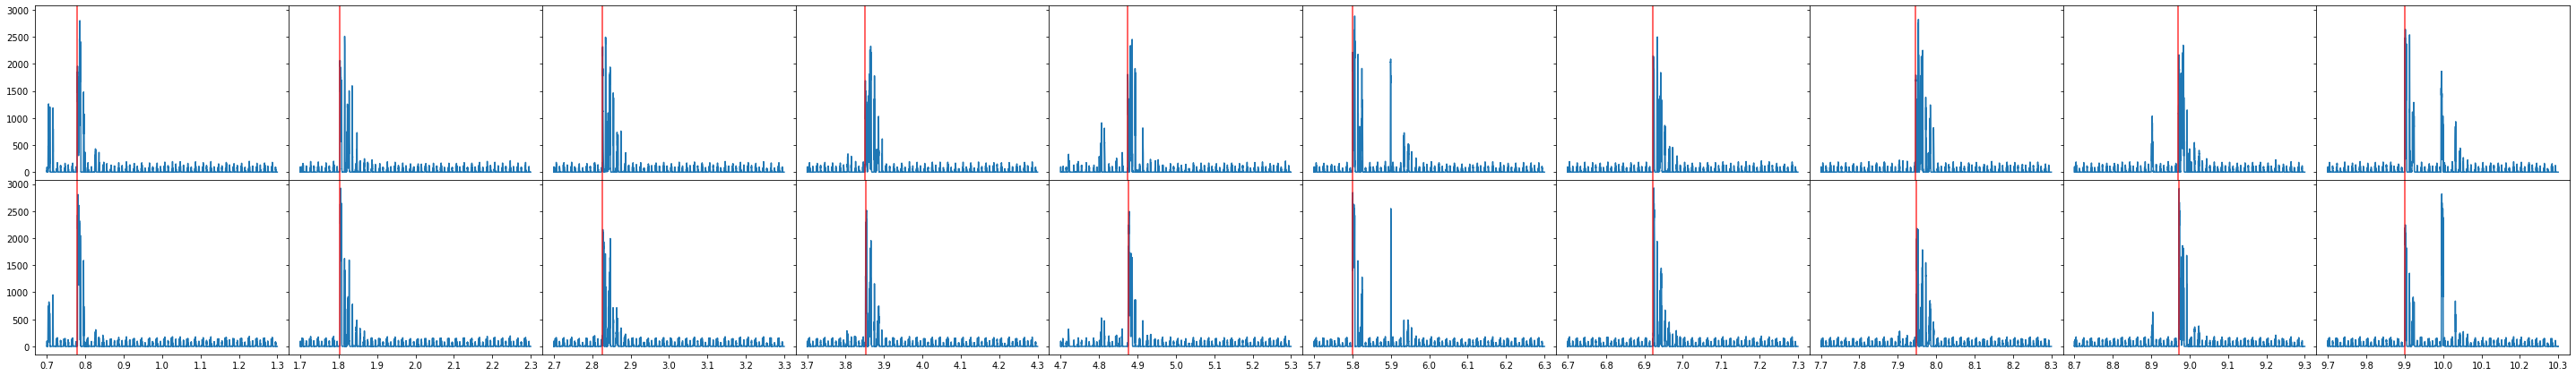

In [ ]:
view_new_pings(*data_loader[0.65, 0], start=0.7)

3.18644 2.8712 158.64416 3.9664 3.2856 3.00588 161.10392 4.46812 4.44 3.01328 

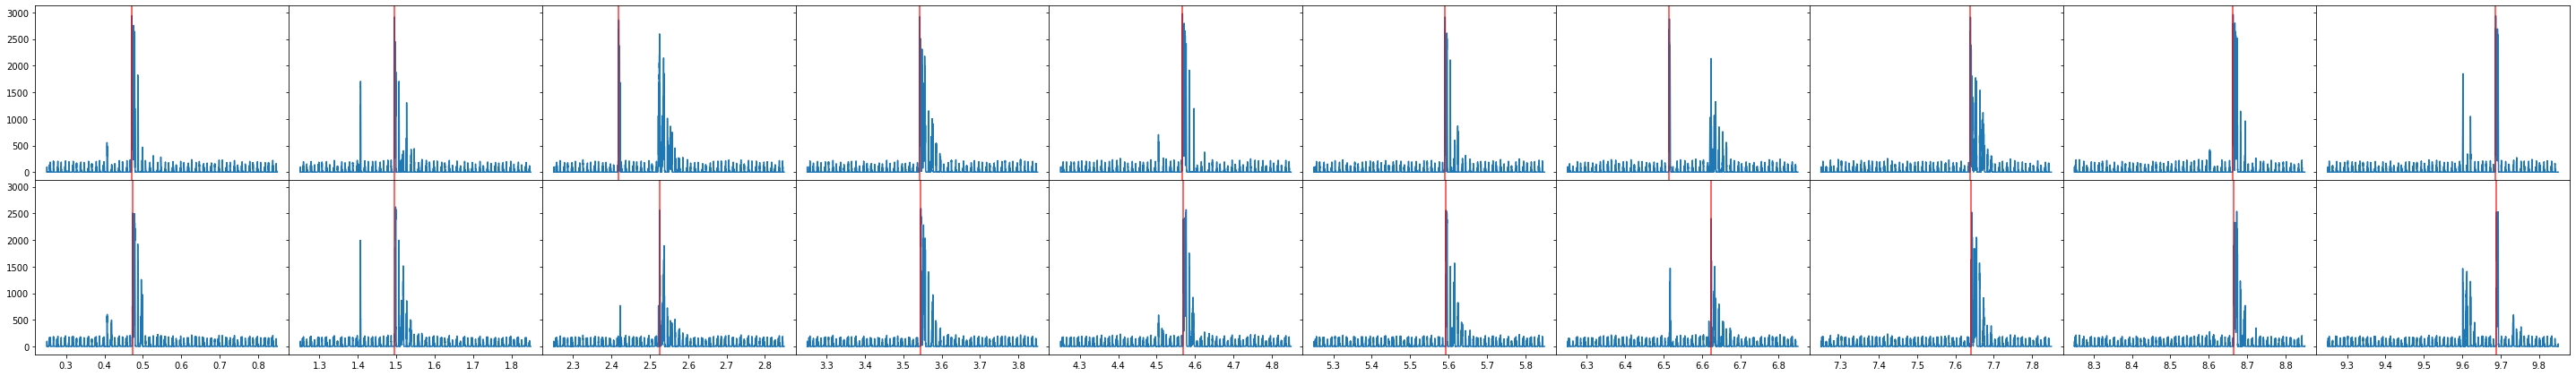

In [ ]:
view_new_pings(*data_loader[1.25, 0], start=0.25)

3.07692 nan 15.39348 2.95556 3.2856 nan nan 13.78768 3.1006 3.31224 

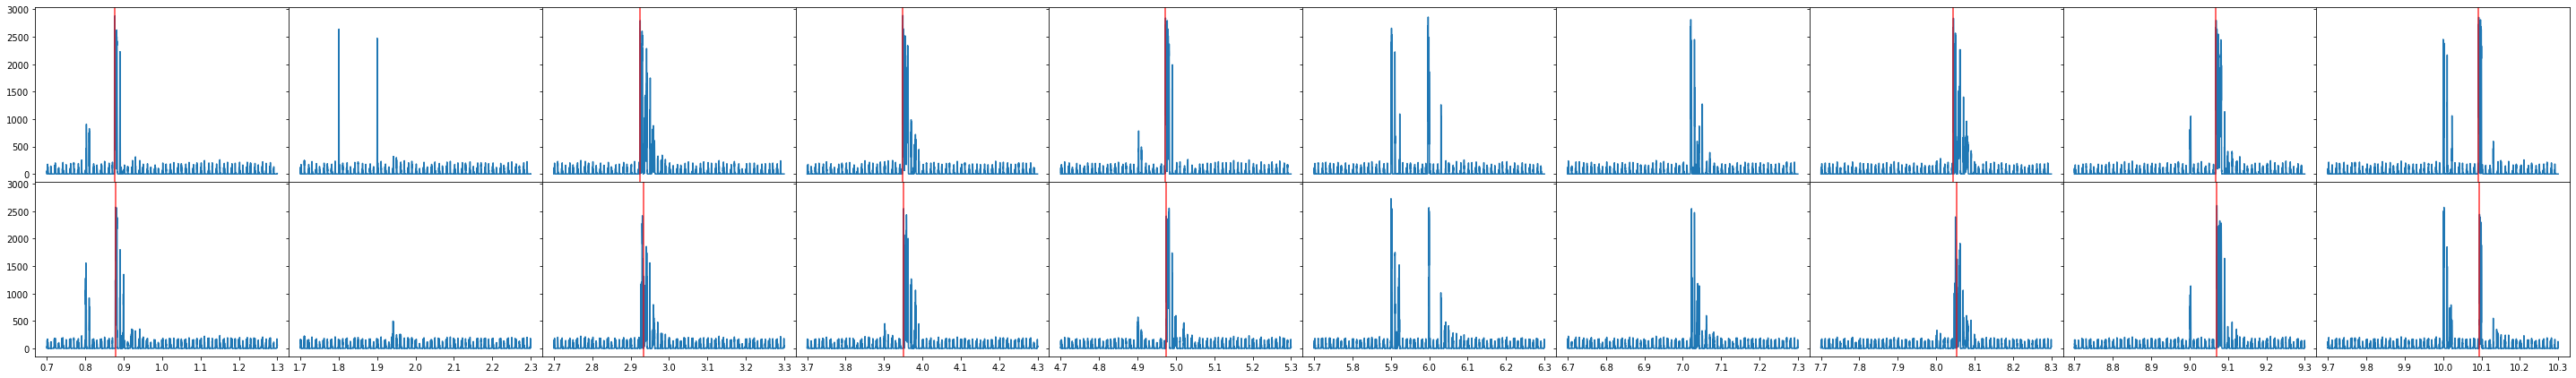

In [ ]:
view_new_pings(*data_loader[1.25, 1], start=0.7)

d000_2:   0%|          | 0/507 [00:00<?, ?it/s]

Got 506 chunks of 507 expected
1.18252 0.49284 0.53132 0.49136 -1.00492 0.58312 0.56832 0.50468 -0.00888 nan 

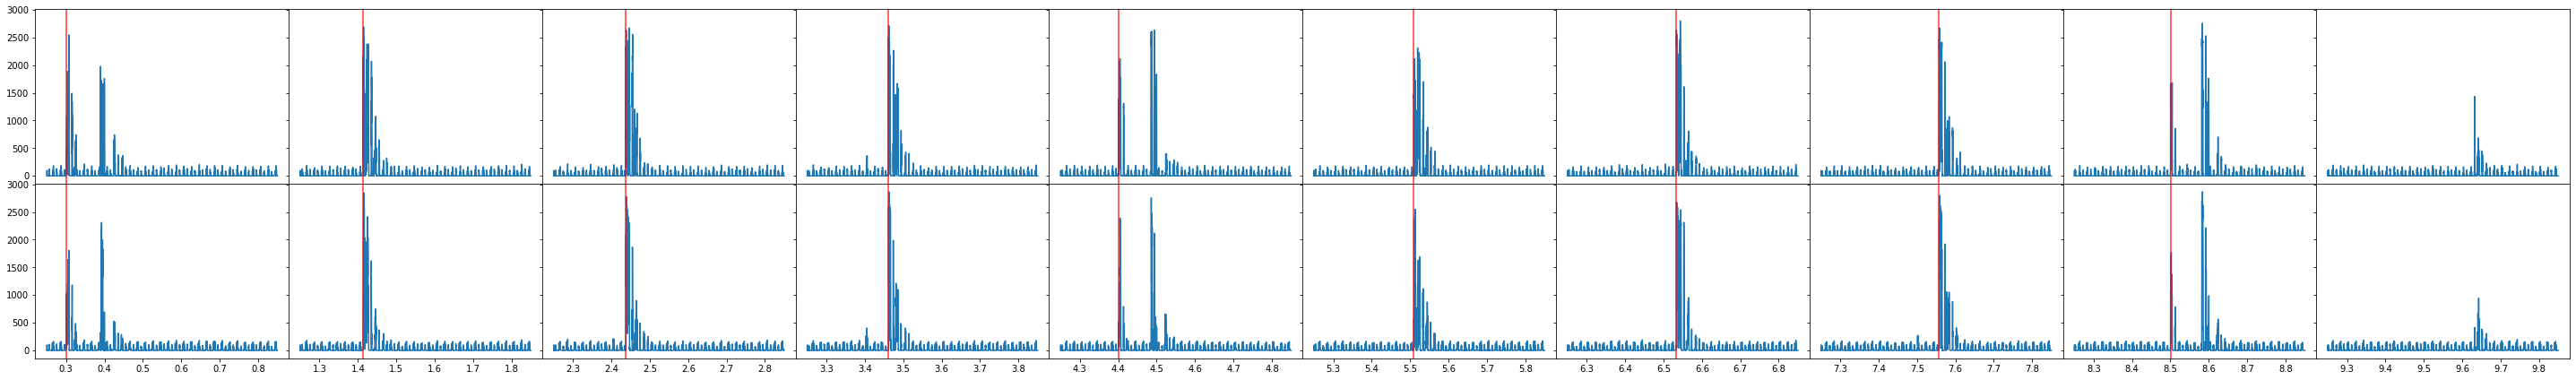

In [ ]:
view_new_pings(*data_loader[0.0, 1], start=0.25)

# Viz Ping widths

## get widths code

In [20]:
# Filter by threhsold,find proto-pings
# Filter by height - 500
# combine nearby pings
# filter by ping width
# One final filter by heigth - 1500
# Filter by time between pings

def get_ping_widths(sig,
                      real_zero=100,
                      max_break_time=0.001,
                      min_peak_time=2e-3,
                      init_min_peak_height=500,
                      min_peak_height=1250,
                      min_time_b_w_peaks=0.0,
                      plot=False):
    x = sig.copy()

    # Ensure no range crosses the boundary
    x[0] = 0
    x[-1] = 0

    sig_mask = x > real_zero
    start_index = np.where(np.diff(sig_mask.astype(int)) > 0)[0]
    end_index = np.where(np.diff(sig_mask.astype(int)) < 0)[0]

    tall_enough_peaks = [True if x[slice(*r)].max() > init_min_peak_height else False for r in
                         zip(start_index, end_index)]
    start_index, end_index = start_index[tall_enough_peaks], end_index[tall_enough_peaks]

    for index in np.where((start_index[1:] - end_index[:-1]) < fs * max_break_time)[0][::-1]:
        start_index = np.delete(start_index, index + 1)
        end_index = np.delete(end_index, index)

    wide_enough_peaks = (end_index - start_index) > fs * min_peak_time
    start_index, end_index = start_index[wide_enough_peaks], end_index[wide_enough_peaks]

    tall_enough_peaks = [True if x[slice(*r)].max() > min_peak_height else False for r in zip(start_index, end_index)]
    start_index, end_index = start_index[tall_enough_peaks], end_index[tall_enough_peaks]

    prev_in = -np.inf
    i = 0
    while i < len(start_index):
        if (start_index[i] - prev_in) > fs * min_time_b_w_peaks:
            prev_in = start_index[i]
            i += 1
        else:
            start_index = np.delete(start_index, i)
            end_index = np.delete(end_index, i)

    return start_index, end_index - start_index, np.array([x[slice(*r)].max() for r in zip(start_index, end_index)])


d125_1:   0%|          | 0/473 [00:00<?, ?it/s]

Got 472 chunks of 473 expected


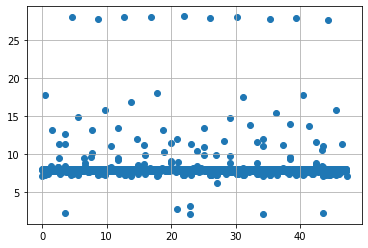

In [21]:
t, y = data_loader[1.25, 0]
ind, width, height = get_ping_widths(y[:, 0])
plt.scatter(t[ind], dt * width * 1000) # , c=height)
# plt.colorbar()
plt.grid()

<IPython.core.display.Javascript object>


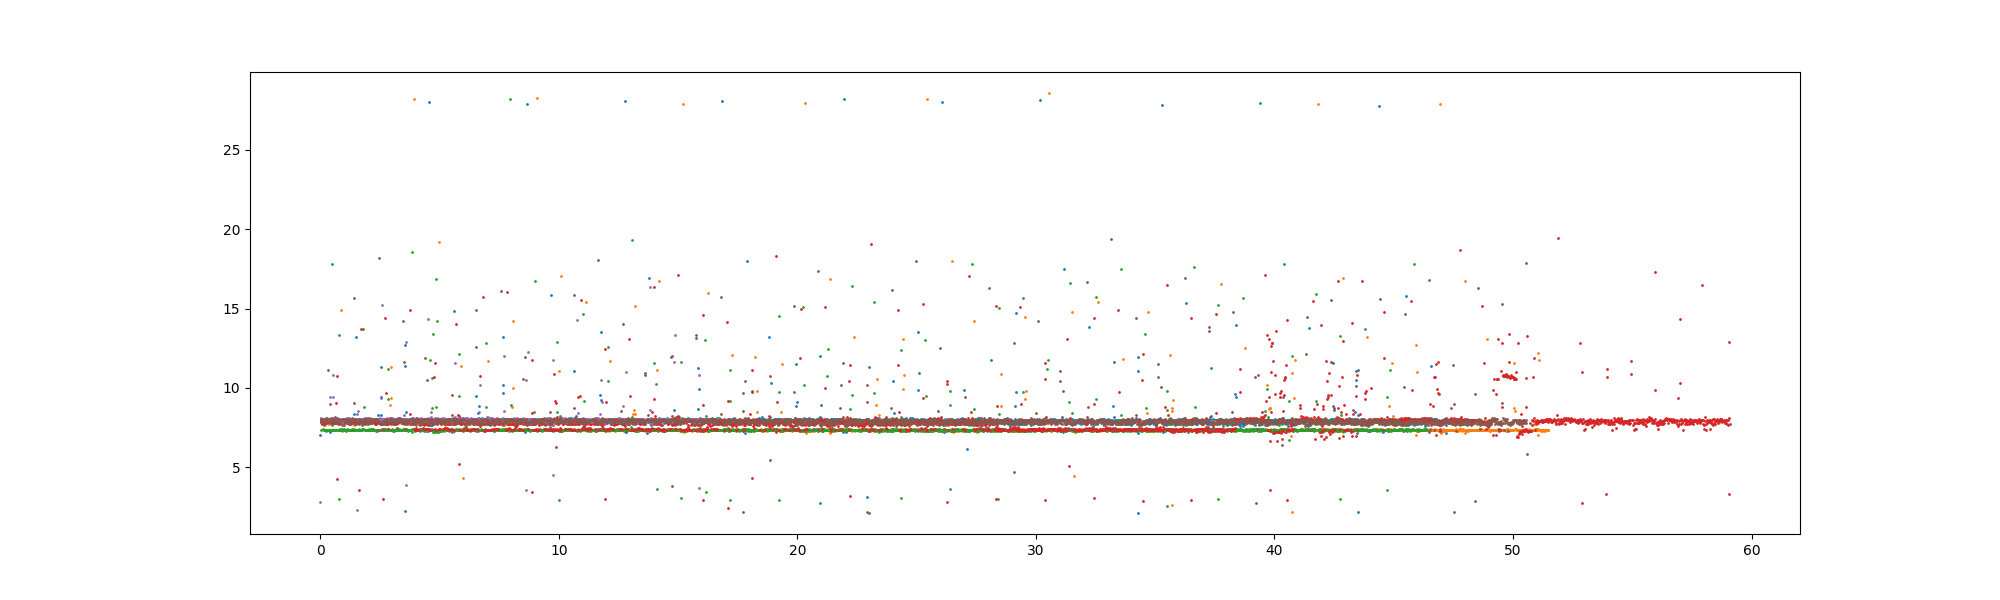

AttributeError: 'AxesSubplot' object has no attribute 'setxlim'

In [24]:
%matplotlib notebook
# f, ax = plt.subplots(1, 6, sharey=True, figsize=(20))
f, ax = plt.subplots(1, 1, sharey=True, figsize=(20, 6))

s = 1


t, y = data_loader[1.25, 0]
ind, width, height = get_ping_widths(y[:, 0])
ax.scatter(t[ind], dt * width * 1000, s=s)

t, y = data_loader[1.25, 1]
ind, width, height = get_ping_widths(y[:, 0])
ax.scatter(t[ind], dt * width * 1000, s=s)

t, y = data_loader[0.65, 0]
ind, width, height = get_ping_widths(y[:, 0])
ax.scatter(t[ind], dt * width * 1000, s=s)

t, y = data_loader[0.65, 1]
ind, width, height = get_ping_widths(y[:, 0])
ax.scatter(t[ind], dt * width * 1000, s=s)

t, y = data_loader[0.00, 0]
ind, width, height = get_ping_widths(y[:, 0])
ax.scatter(t[ind], dt * width * 1000, s=s)

t, y = data_loader[0.00, 1]
ind, width, height = get_ping_widths(y[:, 0])
ax.scatter(t[ind], dt * width * 1000, s=s)

# Figure out Double Signal

In [23]:
t, y = data_loader[0.00, 1]
win = slice(int(fs*4.15), int(fs*4.75))
tt = t[win]
yy = y[win, 0]
plt.plot(tt, BP(**{'fs': fs, 'low': 35e3, 'high': 40e3})(yy))

## Freq Analysis

In [ ]:
import pywt

In [ ]:
scale = np.linspace(5,5000, 50)
f = pywt.scale2frequency('mexh', scale)/dt
f[-1], f[0]

(50.00000000000001, 50000.00000000001)

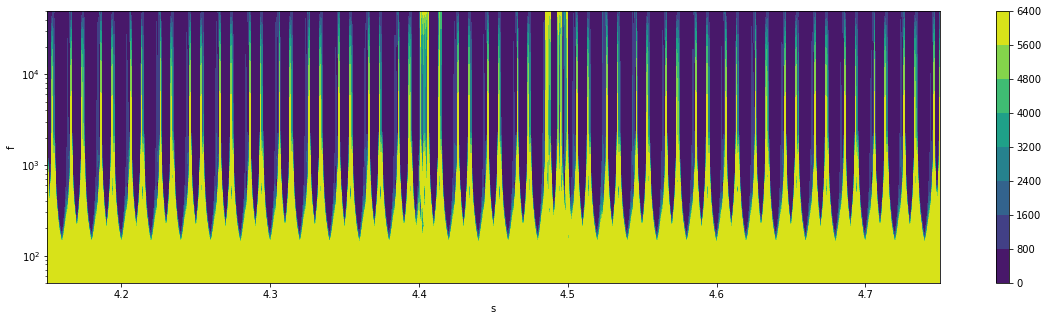

In [ ]:
coef, freqs=pywt.cwt(yy,scale, 'mexh', sampling_period=dt, method='fft')

plt.figure(figsize=(20,5))
plt.contourf(tt, freqs, np.clip(np.abs(coef), 0, 6000))
plt.xlabel('s')
plt.ylabel('f')
plt.gca().set_yscale('log')
plt.colorbar()

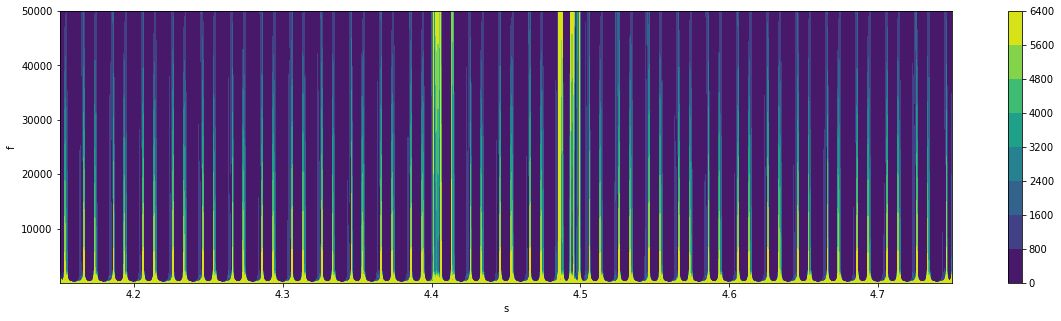

In [ ]:
plt.figure(figsize=(20,5))
plt.contourf(tt, freqs, np.clip(np.abs(coef), 0, 6000))
plt.xlabel('s')
plt.ylabel('f')
# plt.gca().set_yscale('log')
plt.colorbar()
plt.title("Wavelet Plot, linear")

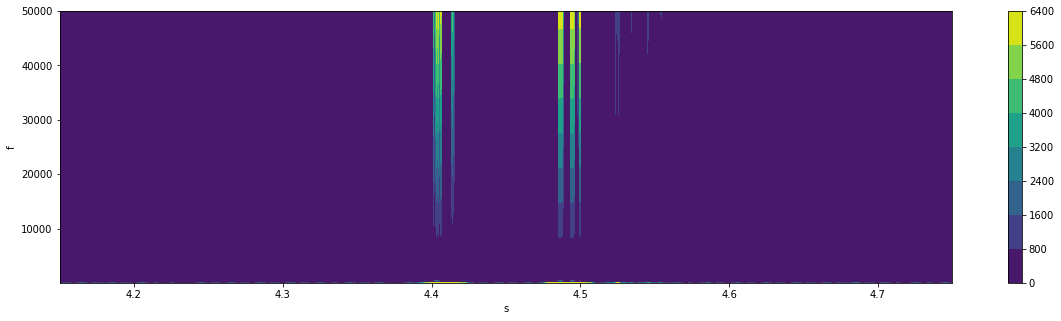

In [ ]:
coef, freqs=pywt.cwt(BP(**{'fs': fs, 'low': 35e3, 'high': 40e3})(yy), scale, 'mexh', sampling_period=dt, method='fft')

plt.figure(figsize=(20,5))
plt.contourf(tt, freqs, np.clip(np.abs(coef), 0, 6000))
plt.xlabel('s')
plt.ylabel('f')
plt.colorbar()
plt.title("Band Passed Wavelet Plot, linear")

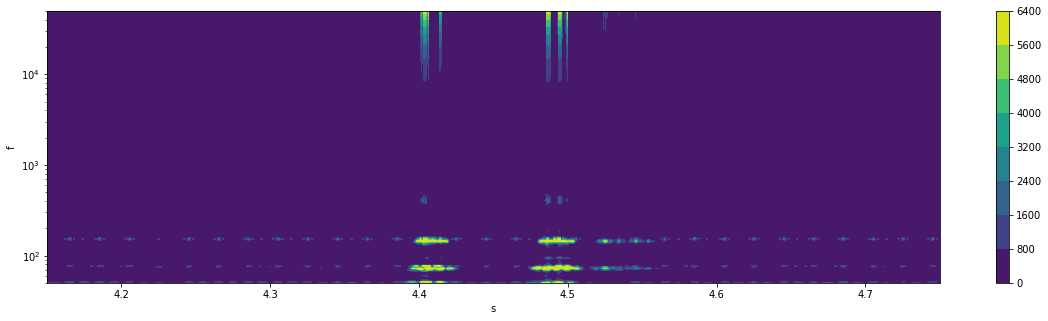

In [ ]:
plt.figure(figsize=(20,5))
plt.contourf(tt, freqs, np.clip(np.abs(coef), 0, 6000))
plt.xlabel('s')
plt.ylabel('f')
plt.gca().set_yscale('log')
plt.colorbar()

**Both real/fake pings both look like they have the same signature, nothing really defining is different**

# Compare with Amit Daud Data

## Get Data

In [ ]:
url = 'https://drive.google.com/file/d/1JV2K3AqffI_EtBXOr2ojJaVxdZw8FO9i/view?usp=sharing'
filename = 'old_amit_data_sample.csv'

In [ ]:
!ls "{filename}" 2>/dev/null || (python -m pip install gdown --upgrade > /dev/null && gdown --fuzzy "{url}")

old_amit_data_sample.csv


In [ ]:
adata = np.loadtxt(filename)
at = np.arange(adata.shape[0]) * dt

## Plot

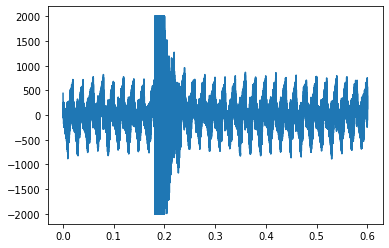

In [ ]:
plt.plot(at, adata)

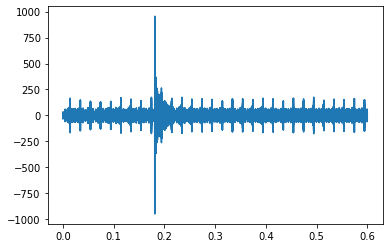

In [ ]:
plt.plot(at, BP(**{'fs': fs, 'low': 35e3, 'high': 40e3})(adata))

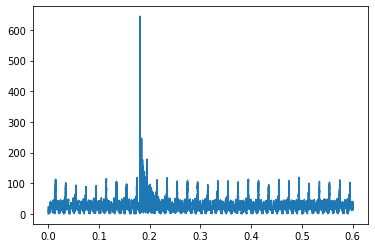

In [ ]:
plt.plot(at, MA(fs=fs, dt=3e-5)(BP(**{'fs': fs, 'low': 35e3, 'high': 40e3})(adata)))

## Freq

In [ ]:
import pywt

In [ ]:
scale = np.linspace(5,5000, 50)
f = pywt.scale2frequency('mexh', scale)/dt
f[-1], f[0]

(50.00000000000001, 50000.00000000001)

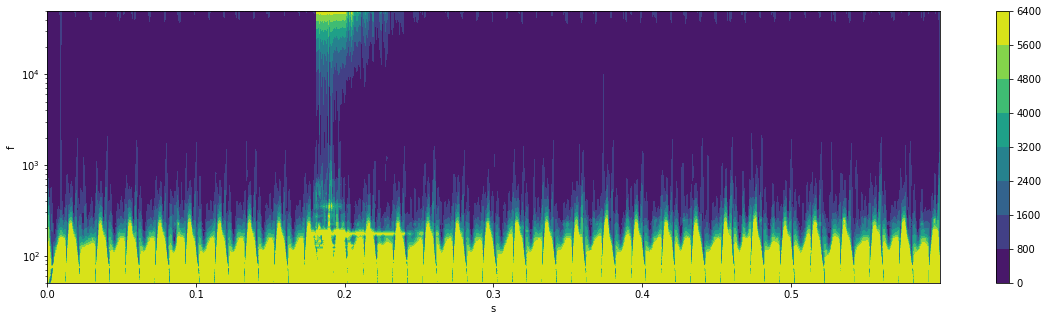

In [ ]:
coef, freqs=pywt.cwt(adata, scale, 'mexh', sampling_period=dt, method='fft')

plt.figure(figsize=(20,5))
plt.contourf(at, freqs, np.clip(np.abs(coef), 0, 6000))
plt.xlabel('s')
plt.ylabel('f')
plt.gca()
plt.colorbar()

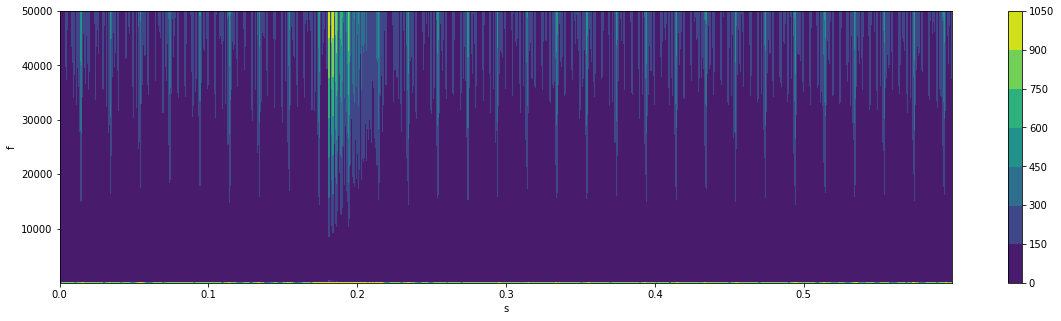

In [ ]:
coef, freqs=pywt.cwt(BP(**{'fs': fs, 'low': 35e3, 'high': 40e3})(adata), scale, 'mexh', sampling_period=dt, method='fft')

plt.figure(figsize=(20,5))
plt.contourf(at, freqs, np.clip(np.abs(coef), 0, 1000))
plt.xlabel('s')
plt.ylabel('f')
plt.gca()
plt.colorbar()

# Basic Viz

## Load Run

In [ ]:
dist = 0.65
t, y = data_loader[dist, 0]

In [ ]:
import matplotlib.pyplot as plt

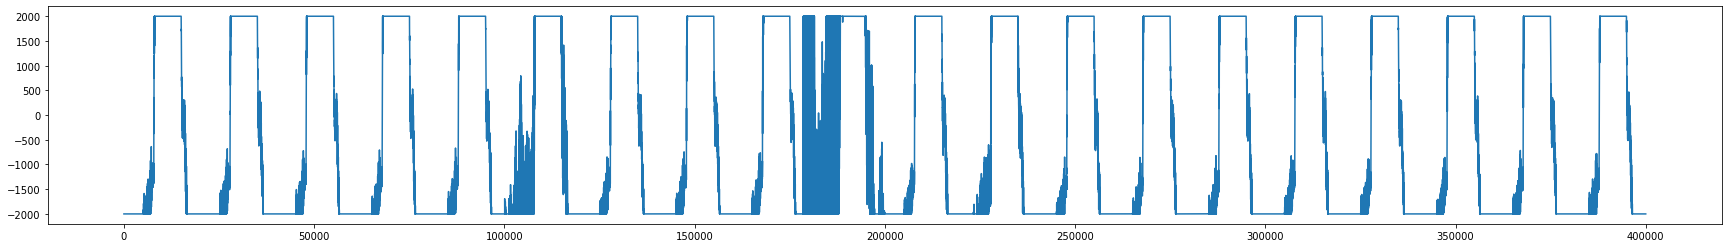

In [ ]:
plt.figure(figsize=(30,4))
plt.plot(y[600000:1000000, 0])

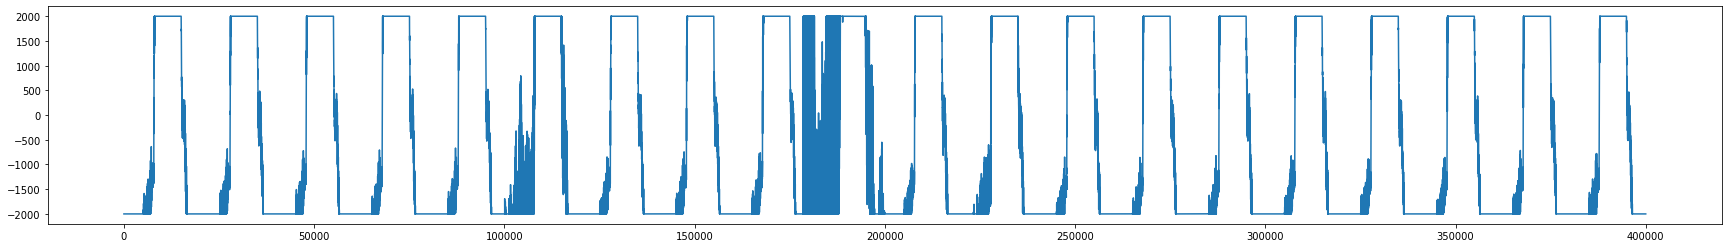

In [ ]:
plt.figure(figsize=(30,4))
plt.plot(y[600000:1000000, 0])

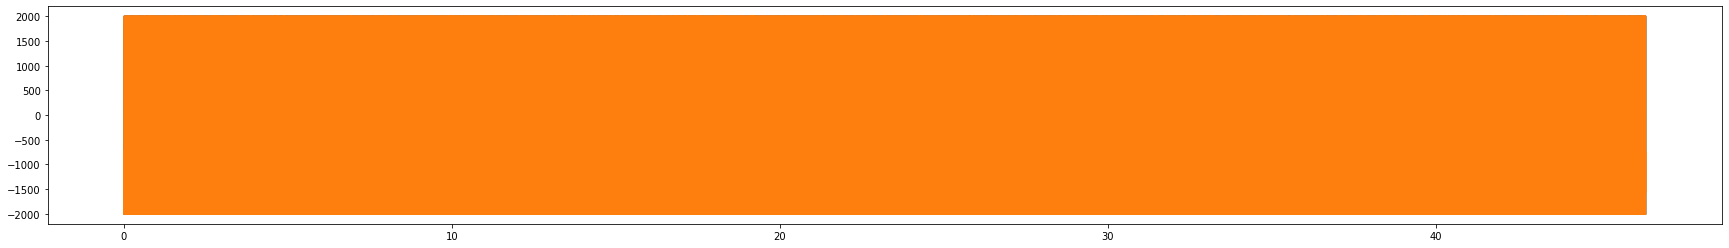

In [ ]:
plt.figure(figsize=(30,4))
plt.plot(t, y)

In [ ]:
ts0 = []
ts1 = []
for t0 in ts:
    start, end = t0 - 0.01, t0 + 0.03
    ind = Est_ZC_stage_1(y[ int(fs * start) : int(fs*end), 1], int(0.004 * fs), 200, run_plot=False)
    if ind == 0:
        print("Missing at t =",t0)
    else:
        ts0.append(t0)
        ts1.append(start + ind * dt)
ts0 = np.array(ts0)
ts1 = np.array(ts1)

NameError: ignored

In [ ]:
ts1 - ts0

In [ ]:
def check_missing(t0):
    loc = ts.searchsorted(t0)
    start, end = t0 - 0.01, t0 + 0.03
    win = slice(int(fs * start), int(fs * end))
    f, ax = plt.subplots(2, 1, sharex=True, figsize=(10, 6))
    t_local = t[win]
    for a, d in zip(ax, y[win, :].T):
        a.plot(t_local, d)
        a.axvline(x=t0, color='red', linewidth=2, alpha=0.5)

    ind0 = Est_ZC_stage_1(y[win, 0], int(0.004 * fs), 200, run_plot=True)
    ind1 = Est_ZC_stage_1(y[win, 1], int(0.004 * fs), 200, run_plot=True)
    print((ind1-ind0)* v_sound / fs)

In [ ]:
check_missing(2.8267292976379395)

In [ ]:
check_missing(4.805675506591797)

# AA